## Analisis de la Encuesta Continua de Hogares 2024

- Dataset: https://www4.ine.gub.uy/Anda5/index.php/catalog/767/get-microdata
- Diccionario: https://www4.ine.gub.uy/Anda5/index.php/catalog/767/data-dictionary/F4?file_name=ECH_implantacion_2024

In [44]:
# IMPORTO LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Carga del dataset

In [45]:
# CARGO EL CSV CON PANDAS
ech = pd.read_csv(r'C:\Users\ut603933\UM\tesis\ECH_implantacion_2024.csv')

In [165]:
# DIMENSIONES Y PRIMERAS FILAS
print("Dimensiones del dataset:", ech.shape)
print("\nPrimeras filas:")
display(ech.head())

Dimensiones del dataset: (55923, 535)

Primeras filas:


,ID,nper,anio,mes,GR,region,REGION_4,dpto,nom_dpto,ccz,barrio,secc,ESTRED13,LOC_AGR_13,NOM_LOC_AGR_13,c1,c2,c3,c4,c5_2,c5_10,c5_11,c5_12,c5_13,c6,c6_1,d8_1,d8_2,d8_3,d8_4,d9,d10,d11,d12,d13,d14,d15,d16,d18,d260,d19,d20,d21_1,d21_2,d21_3,d21_6,d21_4,d21_4_1,d21_5,d21_5_1,d21_20,d21_7,d21_10,d21_11,d21_12,d21_13,d21_14,d21_14_1,d21_15,d21_15_1,d21_15_2,d21_15_3,d21_15_4,d21_15_5,d21_15_6,d21_16,d21_16_1,d21_16_2,d21_21,d21_17,d21_18,d21_18_1,d21_19,d21_19_1,d181,d229,d230,d231,d232,d184,d184_1,d181_b,d184_b,d23,d24,d25,e557,e26,e27,e29_1,e29_2,e29_3,e29_4,e29_5,e29_6,e30,e31,e31_1,e32,e32_1,e33,e34,e35,e36,e185,e186_1,e186_2,e186_3,e186_4,e37,e37_2,e234_2,e38,e38_1,e39,e39_2,e235_2,e236,e236_2,e236_4,e45_cv,e45_1_1_cv,e45_1_1_1_cv,e45_2_1_cv,e45_2_1_1_cv,e45_3_1_cv,e45_3_1_1_cv,e45_4_1_cv,e45_4_1_1_cv,e45_cva,e45_cvb,e46_cv,e47_cv,e47_1_cv,e190,e48,e49,e49a,e579,e583,e581,e579a,e581a,e582,e582_1,e582_2,e582_3,e51_2,e197_1,e51_3,e51_4_a,e201_1a,e51_4_b,e201_1b,e51_5,e201_1c,e51_6,e201_1d,e209_1,e202,e51_6a,e51_6b,e214_1,e51_8,e215_1,e217_1,e51_9,e218_1,e220_1,e51_10,e221_1,e223_1,e51_11,e224_1,e226_1,e559,e559_1,e559_2,e584,e584_1,e59,e246,e247,f269,f270,f271,f272,f273,f69,f69_1,f274,f275,f276,f277,f70,f71_2,f72_2,f73,f82,f83,f84,f278,f278_a,f279,f280_1,f280_2,f280_3,f281_1,f281_2,f281_3,f281_4,f75,f76_2,f283,f81,f266,f266_1,f266_2,f267,f268,f77,f305,f306,f78,f80,f80_2,f284_1,f284_2,f284_3,f284_4,f284_5,f284_6,f284_7,f285,f286,f287,f85,f307,f308,f288,f289,f290,f291_a,f291_b,f292,f293,f294,f295,f90_2,f91_2,f92,f96,f97,f93,f94,f94_2,f296_1,f296_2,f296_3,f296_4,f296_5,f296_6,f296_7,f98,f99,f100,f101,f102,f103,f297,f298,f104,f299,f110,f111,f113,f114,f115,f300,f108,f301,f106,f116,f117,f118_1,f118_2,f122,f119_2,f120_2,f121,f123,f124_1,f124_2,f124_3,f124_5,f125,g_id_1,g_id_2,g_id_3,g_id_1a,g_id_2a,g_id_3a,g126_1,g126_2,g126_3,g126_4,g126_5,g126_6,g126_7,g126_8,g250_1,g250_2,g250_3,g250_4,g250_5,g127,g127_1,g127_2,g127_3,g128,g128_1,g129,g129_1,g129_2,g130,g130_1,g131,g131_1,g132,g132_1,g132_2,g132_3,g133,g133_1,g133_2,g_st_1,g134_1,g134_2,g134_3,g134_4,g134_5,g134_6,g134_7,g134_8,g251_1,g251_2,g251_3,g251_4,g251_5,g135,g135_1,g135_2,g135_3,g136,g136_1,g137,g137_1,g137_2,g138,g138_1,g139,g139_1,g140,g140_1,g140_2,g140_3,g141,g141_1,g141_2,g_itnd_1,g142,g_itnd_2,g143,g144,g144_1,g144_2_1,g144_2_2,g144_2_3,g144_2_4,g144_2_5,g_itnd_3,g259,g_it_1,g148_1_1,g148_1_2,g148_1_3,g148_1_5,g148_1_6,g148_1_7,g148_1_8,g148_1_9,g148_1_10,g148_1_11,g148_1_12,g_it_2,g148_2_1,g148_2_2,g148_2_3,g148_2_5,g148_2_6,g148_2_7,g148_2_8,g148_2_9,g148_2_10,g148_2_11,g148_2_12,g148_3,g148_4,g148_5_1,g148_5_2,g149,g149_1,g150,g255,g256,g152,g151_6,g151_3,g151_4,g257,g153,g153_1,g153_2,g258,g258_1,g154,g154_1,h155,h155_1,h156,h156_1,h272,h272_1,h273,h273_1,h274,h274_1,h274_2,h274_3,h252,h252_1,h158_1,h158_2,h159,h160,h160_1,h160_2,h161,h162,h163_1,h163_2,h164,h165,h227,h166,h269,h269_1,h167_1,h167_1_3,h167_2,h167_2_3,h167_3,h167_3_3,h167_4,h167_4_3,h169,h170_3,h271,h271_1,h171,h171_1,h171_2,h172,h172_1,h173,h173_1,i228,i174,i259,i175,eg_ahorro,eg_ps3,eg_ps4,eg_ps5,eg_ps6,eg_ps7,eg_ps8,eg_ps1,eg_ps2,POBPCOAC,SUBEMPLEO,MTO_CUOTA,MTO_EMER,MTO_HOGCON,MTO_DESAY,MTO_ALMUE,MTO_VACAS,MTO_OVEJA,MTO_CABALL,INDACELIAC,INDAEMER,PT1,PT2,PT4,HT11,HT19,HT13,YSVL,YHOG,AFAM_H_DEC,AFAM_H,TUS_H_DEC,TUS_H,USO_RRAA,pobre06,indig06,lp_06,li_06,pobre_multi,YDA_SVL,lp_17,li_17,pobre17,indig17,monto_imput_UTE,monto_imput_GAS,monto_imput_OSE,H_FONASA,montoGAS_RRAA,montoUTE_RRAA,montoOSE_RRAA,YDA,W_TRI,W_SEM,W_ANO
0,57612,1,2024,1,31,1,1,1,Montevideo,1,2,1,4,1010,Montevideo,3,1,1,1,2,2,2,2,NaN,1,0,5,0,18000,2,2,1,1,1,1,1,1,1,1,6,1,3,1,2,1,2,2,0,1,1,2,1,1,2,2,1,2,0,1,2,0,1,1,2,0,1,1,2,2,1,2,0,2,0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN,NaN,1,0,1,1,2,70,2,2,1,2,2,0,1,0,0,0,0,2,0,0,4,1,0,2,0,1,1,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,1,7,0,1,2,0,3,1,1,20,0,0,0,0,0,0,0,0,0,6,1,0,3,1,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,0,0,2,2,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [166]:
# TIPOS DE DATOS
print("\nTipos de datos:")
display(ech.dtypes.value_counts())


Tipos de datos:


int64      484
float64     49
object       2
Name: count, dtype: int64

In [167]:
# MOSTRAR TODAS LAS COLUMNAS SIN TRUNCAR
pd.set_option('display.max_columns', None)  # muestra todas las columnas
pd.set_option('display.expand_frame_repr', False)  # evita salto de línea

# MOSTRAR TODOS LOS NOMBRES DE COLUMNAS
print(ech.columns.tolist())

['ID', 'nper', 'anio', 'mes', 'GR', 'region', 'REGION_4', 'dpto', 'nom_dpto', 'ccz', 'barrio', 'secc', 'ESTRED13', 'LOC_AGR_13', 'NOM_LOC_AGR_13', 'c1', 'c2', 'c3', 'c4', 'c5_2', 'c5_10', 'c5_11', 'c5_12', 'c5_13', 'c6', 'c6_1', 'd8_1', 'd8_2', 'd8_3', 'd8_4', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd18', 'd260', 'd19', 'd20', 'd21_1', 'd21_2', 'd21_3', 'd21_6', 'd21_4', 'd21_4_1', 'd21_5', 'd21_5_1', 'd21_20', 'd21_7', 'd21_10', 'd21_11', 'd21_12', 'd21_13', 'd21_14', 'd21_14_1', 'd21_15', 'd21_15_1', 'd21_15_2', 'd21_15_3', 'd21_15_4', 'd21_15_5', 'd21_15_6', 'd21_16', 'd21_16_1', 'd21_16_2', 'd21_21', 'd21_17', 'd21_18', 'd21_18_1', 'd21_19', 'd21_19_1', 'd181', 'd229', 'd230', 'd231', 'd232', 'd184', 'd184_1', 'd181_b', 'd184_b', 'd23', 'd24', 'd25', 'e557', 'e26', 'e27', 'e29_1', 'e29_2', 'e29_3', 'e29_4', 'e29_5', 'e29_6', 'e30', 'e31', 'e31_1', 'e32', 'e32_1', 'e33', 'e34', 'e35', 'e36', 'e185', 'e186_1', 'e186_2', 'e186_3', 'e186_4', 'e37', 'e37_2', 'e234_2', 'e

In [168]:
# VEMOS SI HAY COLUMNAS DUPLICADAS POR NOMBRES
duplicated_cols = ech.columns[ech.columns.duplicated()].tolist()
print("Columnas duplicadas por nombre:", duplicated_cols)

Columnas duplicadas por nombre: []


No hay columnas duplicadas en el dataset original. 

Las columnas que aparecian duplicadas y no permitian ejecutar el pipeline las repetiamos erroneamente al categorizar las variables porque si aparecen duplicadas en el Excel del diccionario.

## Analisis exploratorio de datos

In [169]:
# ANALISIS DE VALORES NULOS
nulos = ech.isnull().sum()
nulos = nulos[nulos > 0].sort_values(ascending=False)
print("\nColumnas con nulos (cantidad):")
display(nulos)


Columnas con nulos (cantidad):


f295      28066
f293      28066
d229      28066
d230      28066
d231      28066
d232      28066
d184      28066
d184_1    28066
f294      28066
d181      28066
f288      28066
f289      28066
f290      28066
f291_a    28066
f291_b    28066
f292      28066
c5_13     27857
d181_b    27857
d184_b    27857
dtype: int64

Verificando el diccionario, los valores nulos son para las variables:
- c5_13: PROBLEMAS DE LA VIVIENDA Pisos y muros agrietados
- d181, d181_b, d184, d184_1, d184_b, d229, d230, d231, d232: SERVICIO DOMESTICO
- f288, f289, f290, f291_a, f291_b, f292, f293, f294, f295: Lugar y modalidad de trabajo

In [170]:
nulos_pct = ech.isnull().mean().sort_values(ascending=False)
display(nulos_pct[nulos_pct > 0])

f288      0.501869
f295      0.501869
d231      0.501869
d230      0.501869
d229      0.501869
d181      0.501869
d184_1    0.501869
d184      0.501869
f289      0.501869
f290      0.501869
f291_a    0.501869
f291_b    0.501869
f292      0.501869
f293      0.501869
f294      0.501869
d232      0.501869
d181_b    0.498131
d184_b    0.498131
c5_13     0.498131
dtype: float64

Las preguntas son de los modulos:
-   Servicio doméstico → sólo hogares que contratan personal.
-   Lugar y modalidad de trabajo → sólo personas ocupadas.

Confirmamos que son variables condicionales por diseño: 
-   La mitad de la población no responde esas preguntas porque no aplica.
-   El 50% restante sí tiene datos válidos y útiles.

No eliminamos esas columnas por tener “demasiados nulos”, ya que no se trata de datos ausentes por error, sino de lógica del cuestionario.

Podemos usarlas de forma segmentada, por ejemplo:
-   Hacer modelos distintos para personas ocupadas (que tienen datos en f288–f295) y no ocupadas, o
-   Incluir una variable indicadora de “aplica o no aplica” para evitar que el modelo se confunda.

Son una señal indirecta de pertenencia a ciertos grupos: tener datos en esas columnas podría implicar estar ocupado o tener personal a cargo → lo que sí puede estar correlacionado con el ingreso.


Estadísticas de ingreso (YDA):


count    5.592300e+04
mean     1.063283e+05
std      9.331071e+04
min      0.000000e+00
25%      5.400000e+04
50%      8.187355e+04
75%      1.270000e+05
max      2.560000e+06
Name: YDA, dtype: float64

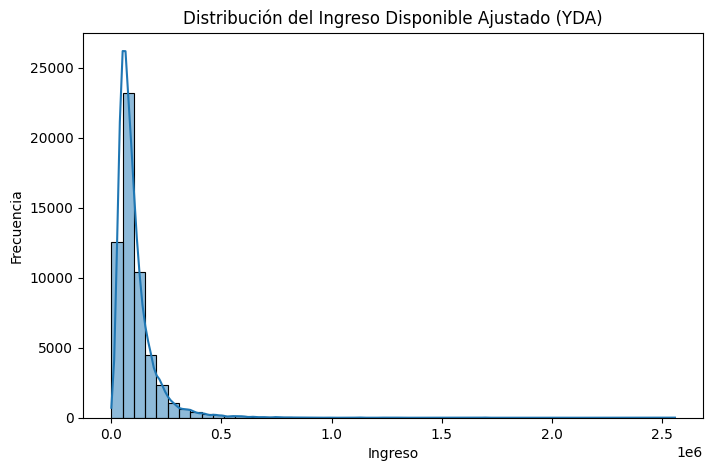

In [171]:
# DISTRIBUCION DE LA VARIABLE OBJETIVO
# Suponemos que la variable objetivo es 'YDA'
target = 'YDA'
print("\nEstadísticas de ingreso (YDA):")
display(ech[target].describe())

plt.figure(figsize=(8,5))
sns.histplot(ech[target], bins=50, kde=True)
plt.title('Distribución del Ingreso Disponible Ajustado (YDA)')
plt.xlabel('Ingreso')
plt.ylabel('Frecuencia')
plt.show()

Se observa que:
- Muy asimétrica (sesgo a la derecha).
- Muchos ingresos entre $0 y $200.000.
- Algunos valores extremos que superan el millón (outliers evidentes).

Tratamos a continuacion: 
- Usmos la variable log_YDA como target en modelos lineales y árboles si queremos reducir la sensibilidad a los valores extremos.
- Visualizamos un boxplot ya que el max es 25 veces el 75º percentil.
- Vemos valores en 0 ya que min = 0 → ¿Ingreso nulo o inactivo?

In [172]:
# TARGET DE MODELOS LINEALES Y ARBOLES SI QUEREMOS REDUCIR LA SENSIBILIDAD A LOS VALORES EXTREMOS
ech['log_YDA'] = np.log1p(ech['YDA'])  # log(1 + YDA)

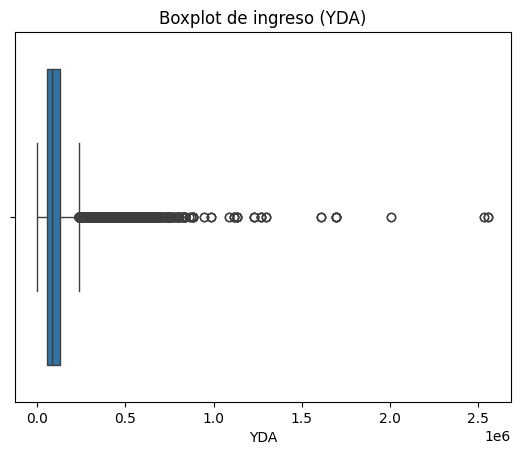

In [173]:
# VISUALIZAMOS CON BOXPLOT
sns.boxplot(x=ech['YDA'])
plt.title("Boxplot de ingreso (YDA)")
plt.show()

La gráfica muestra claramente lo que ya anticipamos:
- Una alta concentración de valores en el rango bajo (entre $0 y $200.000).
- Una larga cola derecha de outliers extremos, que se extienden hasta los 2.5 millones.

Esto confirma que:
- El ingreso en la ECH 2024 está fuertemente sesgado.
- La dispersión es muy alta.
- Los outliers son numerosos pero no necesariamente errores.

In [174]:
# VEMOS VALORES EN CERO
ech[ech['YDA'] == 0].shape

(12, 536)

Esto significa que solo 12 personas tienen ingreso 0 declarado, lo cual:
- No es un problema de datos generalizado, ni requiere imputación.
- Pero sí vale la pena entender el perfil de estas 12 personas.

In [175]:
display(ech[ech['YDA'] == 0][['e27', 'e26', 'f269', 'd8_1', 'd9', 'c1']])  # o las columnas que representen edad, ocupación, tipo de hogar

,e27,e26,f269,d8_1,d9,c1
1186,30,1,2,5,1,3
3174,64,1,2,5,3,1
3175,61,2,2,5,3,1
5722,52,1,1,5,2,1
12984,61,1,2,5,2,2
24402,49,1,2,5,2,3
39054,51,2,1,1,3,1
39055,64,1,2,1,3,1
48247,26,1,1,6,2,1
55002,47,2,2,5,1,4


La mayoria inquilinos o arrendatarios (d8_1).

La distribución de YDA:
- Se comporta como es esperable en datos de ingreso.
- No requiere imputación de nulos en YDA (no hay).

Conclusiones clave:
- Los valores extremos están presentes, pero no dominan.
- No es necesario eliminarlos todavía. Algunos modelos (como árboles) los manejan bien.

Transformación logarítmica es aconsejable.
Especialmente para modelos sensibles a la escala o distribución (Regresión Lineal, Redes Neuronales).

Pocos casos con ingreso cero.
Son casos especiales que podés dejar o filtrar si hacés segmentación (ej. "ocupados", "con ingreso distinto de cero", etc.).

Sí se beneficia de:
- Log-transformación (log1p).
- Revisión de outliers extremos.
- Segmentación posterior por tipo de población (ocupada/no ocupada).

In [176]:
ech.shape

(55923, 536)

In [177]:
# IDENTIFICAMOS VARIABLES NUMERICAS Y CATEGORICAS
num_vars = ech.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_vars = ech.select_dtypes(include=['object', 'category']).columns.tolist()

# ELIMINAMOS LA VARIABLE TARGET DE AMBAS LISTAS SI ESTA INCLUIDA
if target in num_vars: num_vars.remove(target)
if target in cat_vars: cat_vars.remove(target)

print(f"Variables numéricas: {len(num_vars)}")
print(f"Variables categóricas: {len(cat_vars)}")

Variables numéricas: 533
Variables categóricas: 2


In [178]:
cat_vars

['nom_dpto', 'NOM_LOC_AGR_13']

Descartamos las variables categoricas para quedarnos con un dataset numerico ya que estas variables tambien estan como numericas en las siguientes variables:
- dpto: Código correlativo del 1 al 19 comenzando por Montevideo y continuando alfabéticamente.
- LOC_AGR_13: Código de las localidades agrupadas donde se releva la ECH.

In [179]:
# ELIMINAR LAS VARIABLES CATEGORICAS
ech = ech.drop(columns=cat_vars, errors='ignore')

print("✅ Variables eliminadas:", cat_vars)
print("Shape resultante:", ech.shape)

✅ Variables eliminadas: ['nom_dpto', 'NOM_LOC_AGR_13']
Shape resultante: (55923, 534)


Muchas de las variables numericas son categóricas que están codificadas numéricamente, por ejemplo:
- sexo: 1 = Hombre, 2 = Mujer
- estado civil actual: 1 = Separado, 2 = Divorciado, 3 = Casado, etc.
- nivel que esta cursando: 4 = Educacion media basica, 6 = Educacion media superior, etc.

Estas se almacenan como int64 o float64, por lo que pandas las interpreta como numéricas, cuando en realidad son categóricas, ordinales o nominales.

Imputación condicional basada en la lógica del cuestionario:

Si PERSONAS PAGAS PARA REALIZAR TAREAS DOMÉSTICAS O DE CUIDADOS d181 (*) 1 = Sí / 2 = No es 2 = No entonces:
- PERSONAS CONTRATADAS PARA REALIZAR TAREAS  DOMÉSTICAS O DE CUIDADO d229 (*) N° Cantidad de personas contratadas es 0.
- CANTIDAD DE HORAS TRABAJADAS A LA SEMANA d230 (*) N° Cantidad de horas habitualmente trabajadas en la semana es 0.
- PERNOCTA EN EL HOGAR d231 (*) 1 = Sí / 2 = No es 2 = No.
- CANTIDAD DE PERSONAS QUE PERNOCTAN d232 (*) N° Cantidad de personas que pernoctan en el hogar es 0.

Si AYUDA GRATUITA DE OTROS FAMILIARES QUE NO INTEGRAN EL HOGAR d184 (*) 1 = Sí / 2 = No es 2 = No entonces:
- CANTIDAD DE HORAS TRABAJADAS A LA SEMANA d184_1 (*) N° Cantidad de horas habitualmente trabajadas en la semana es 0.

In [180]:
# Si d181 == 2 (no tiene servicio doméstico), completar columnas relacionadas

# Estas deben ser 0 si están vacías
for col in ['d229', 'd230', 'd232']:
    ech.loc[(ech['d181'] == 2) & (ech[col].isnull()), col] = 0

# Esta debe ser 2 si está vacía (respuesta negativa explícita)
ech.loc[(ech['d181'] == 2) & (ech['d231'].isnull()), 'd231'] = 2

# Si d184 == 2 (no tiene ayuda gratuita), entonces d184_1 debe ser 0 si está vacía
ech.loc[(ech['d184'] == 2) & (ech['d184_1'].isnull()), 'd184_1'] = 0

In [181]:
# Verificación de valores nulos después de imputación corregida
cols_verificar = ['d229', 'd230', 'd231', 'd232', 'd184_1']

print("Verificación de valores nulos en variables imputadas:")
print(ech[cols_verificar].isnull().sum())

Verificación de valores nulos en variables imputadas:
d229      28066
d230      28066
d231      28066
d232      28066
d184_1    28066
dtype: int64


Si f269 TRABAJO LA SEMANA ANTERIOR es 2 = No imputamos las siguientes variables tambien como 2 = No:
- f290 USO DE PC, TELÉFONO INTELIGENTE O TABLETA PARA TRABAJAR
- f291_a OTRO LUGAR DIFERENTE AL HOGAR, LOCAL PROPIO U OFICINA O INSTALACIÓN DEL CLIENTE
- f291_b TRABAJO EN UN LUGAR DIFERENTE AL HOGAR O AL LUGAR HABITUAL DE TRABAJO
- f292 TRABAJO REALIZADO FUERA DE SUS PROPIAS INSTALACIONES
- f295 TRABAJO SEMANAL EN 2 LUGARES DIFRENTES A LAS INSTALACIONES DEL EMPLEADOR/A O PROPIO LOCAL

In [182]:
cols_f269 = ['f290', 'f291_a', 'f291_b', 'f292', 'f293', 'f295']
for col in cols_f269:
    ech.loc[(ech['f269'] == 2) & (ech[col].isnull()), col] = 2

Unificacion de variables d181 con d181_b y d184 con d184_b:

- d181 y d181_b miden lo mismo ("personas pagas para tareas domésticas o de cuidados"), pero en distintos semestres.
- d184 y d184_b también miden lo mismo ("ayuda gratuita de familiares fuera del hogar").
- Ambas parejas de variables tienen 50% de valores nulos complementarios, por lo que es totalmente válido consolidarlas en una nueva variable que conserve el significado original.

Para cada par, usamos el valor no nulo que exista.

Si los dos valores son nulos (por ejemplo, por no aplicar), la variable consolidada también quedará nula.

Primero recodificamos d181_b y d184_b a binario, ya que toman valores 1, 2 y 3 para Si y 1 y 2 para Si respectivamente.

In [183]:
# Contamos cuántos ceros hay en d181 y d184 antes de imputar
n_d181_ceros = (ech['d181'] == 0).sum()
n_d184_ceros = (ech['d184'] == 0).sum()

print(f"Cantidad de ceros en d181: {n_d181_ceros}")
print(f"Cantidad de ceros en d184: {n_d184_ceros}")

Cantidad de ceros en d181: 260
Cantidad de ceros en d184: 260


Imputación de valores 0 en d181 y d184:

Durante el procesamiento inicial, se imputaron valores 0 en d181 y d184 en casos donde no se respondió la pregunta sobre servicio doméstico o ayuda gratuita.

Estos 0 representan casos no aplicables (por ejemplo, hogares sin servicio doméstico), por lo tanto, decidimos reemplazarlos por el valor 2 (No) antes de crear las columnas unificadas d181_unificado y d184_unificado.

Esto evita que la unificación resulte en valores faltantes injustificados y preserva la lógica del cuestionario.

In [184]:
# Reemplazamos 0 por 2 (No aplica) en las variables d181 y d184 antes de unificarlas
ech.loc[ech['d181'] == 0, 'd181'] = 2
ech.loc[ech['d184'] == 0, 'd184'] = 2

In [185]:
# Recodificar d181_b a binario (1 = Sí, 2 = No)
d181_b_bin = ech['d181_b'].map({1: 1, 2: 1, 3: 1, 4: 2})

# Unificar d181 y d181_b
ech['d181_unificado'] = ech['d181'].combine_first(d181_b_bin)

# Recodificar d184_b a binario (1 = Sí, 2 = No)
d184_b_bin = ech['d184_b'].map({1: 1, 2: 1, 3: 2})

# Unificar d184 y d184_b
ech['d184_unificado'] = ech['d184'].combine_first(d184_b_bin)

In [186]:
# Código de validación para las columnas unificadas
# Validar que no haya valores nulos
print("Valores nulos en columnas unificadas:")
print(ech[['d181_unificado', 'd184_unificado']].isnull().sum())

# Validar que solo haya valores 1 o 2
print("\nValores únicos en d181_unificado:")
print(ech['d181_unificado'].value_counts(dropna=False).sort_index())

print("\nValores únicos en d184_unificado:")
print(ech['d184_unificado'].value_counts(dropna=False).sort_index())

# Validar proporción de respuestas "Sí" y "No"
print("\nProporción de respuestas (1 = Sí, 2 = No):")
print("d181_unificado:")
print(ech['d181_unificado'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

print("d184_unificado:")
print(ech['d184_unificado'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

Valores nulos en columnas unificadas:
d181_unificado    0
d184_unificado    0
dtype: int64

Valores únicos en d181_unificado:
d181_unificado
1.0     4508
2.0    51415
Name: count, dtype: int64

Valores únicos en d184_unificado:
d184_unificado
1.0     2371
2.0    53552
Name: count, dtype: int64

Proporción de respuestas (1 = Sí, 2 = No):
d181_unificado:
d181_unificado
2.0    91.94%
1.0     8.06%
Name: proportion, dtype: object
d184_unificado:
d184_unificado
2.0    95.76%
1.0     4.24%
Name: proportion, dtype: object


Esto implica que solo 8 de cada 100 hogares pagan a una persona por tareas domésticas o cuidados. Esto es completamente razonable en el contexto uruguayo, dado que este tipo de contratación suele estar concentrada en hogares de mayor poder adquisitivo o con necesidades específicas de cuidado. Son coherentes con lo esperado para la población general en una encuesta nacional.

Menos del 5% de los hogares reciben ayuda gratuita de otros familiares que no integran el hogar. También es razonable. La solidaridad familiar informal existe, pero no es una práctica diaria ni generalizada como para que aparezca en un alto porcentaje en una encuesta estructurada.

Ambas proporciones:
- Son coherentes con lo esperado para la población general en una encuesta nacional.
- Validan que la lógica de unificación y recodificación fue correcta.
- No presentan valores anómalos o distribuciones sesgadas artificialmente (como hubiera pasado si imputaras todo como 2 sin justificación).

In [187]:
# Eliminamos las columnas originales si ya no las necesitamos
ech.drop(columns=['d181', 'd181_b', 'd184', 'd184_b'], inplace=True)


Top 10 variables correlacionadas con el ingreso (YDA):


HT11        0.998246
YDA_SVL     0.991424
YSVL        0.988927
log_YDA     0.822117
d8_3        0.663271
eg_ps2      0.599231
HT13        0.584917
d14         0.573026
d21_15_4    0.558708
PT1         0.515934
Name: YDA, dtype: float64

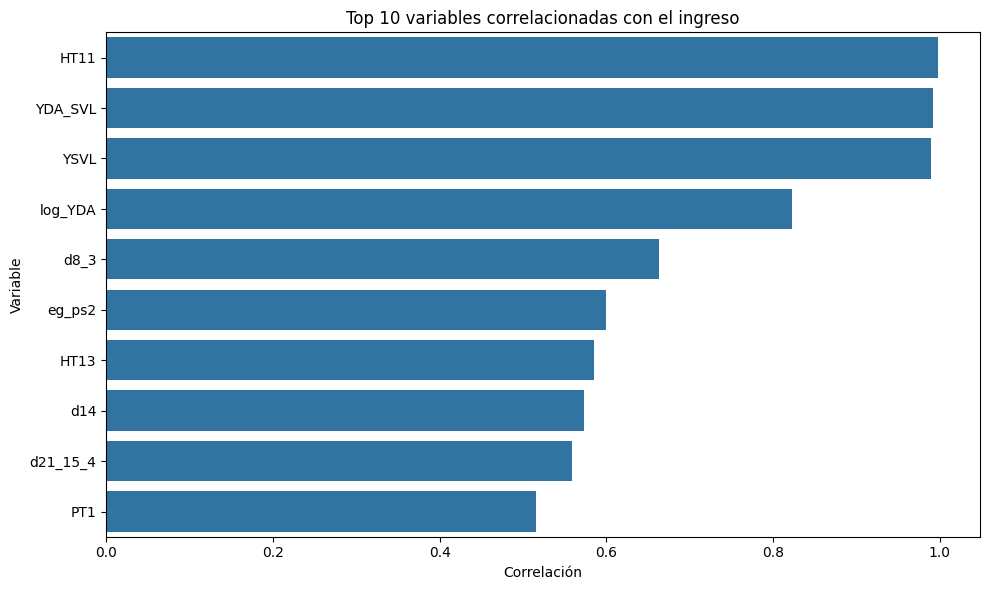

In [188]:
# VEMOS CORRELACION CON LA VARIABLE OBJETIVO
# Seleccionamos solo las columnas numéricas para evitar errores
ech_numericas = ech.select_dtypes(include=['number'])

# Calculamos correlaciones solo sobre esas columnas
correlaciones = ech_numericas.corr()[target].drop(target).sort_values(ascending=False)

# Mostramos resultados
print("\nTop 10 variables correlacionadas con el ingreso (YDA):")
display(correlaciones.head(10))

# Graficamos
plt.figure(figsize=(10,6))
sns.barplot(x=correlaciones.head(10).values, y=correlaciones.head(10).index)
plt.title("Top 10 variables correlacionadas con el ingreso")
plt.xlabel("Correlación")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

Verificando el diccionario, las variables correlacionadas con el ingreso son:
- HT11: INGRESO TOTAL DEL HOGAR CON VALOR LOCATIVO SIN SERVICIO DOMÉSTICO
- YDA_SVL: INGRESO DISPONIBLE AJUSTADO (SIN VALOR LOCATIVO)
- YSVL: INGRESO TOTAL DEL HOGAR SIN VALOR LOCATIVO SIN SERVICIO DOMÉSTICO
- d8_3: TENENCIA DE LA VIVIENDA > Monto del alquiler (efectivamente pagado o estimado)
- eg_ps2: MONTO MÍNIMO MENSUAL REQUERIDO PARA SATISFACER LAS NECESIDADES BÁSICAS
- HT13: VALOR LOCATIVO
- d14: CANTIDAD DE BAÑOS
- d21_15_4: ELEMENTOS DE CONFORT > Cantidad de microcomputadores que no son del Plan Ceibal
- PT1: TOTAL DE INGRESOS PERSONALES
- d21_14_1: ELEMENTOS DE CONFORT > Cantidad de equipos de aire acondicionado

Profundizamos en la correlacion con la variable objetivo:
- Usar correlación de Pearson para variables numéricas → detectar alta correlación con YDA o log_YDA.
- Usar feature importance rápida con un modelo tipo RandomForestRegressor para detectar también correlación no lineal o relaciones más complejas.
- Generar un listado de columnas candidatas a eliminar.

Buscamos detectar variables muy correlacionadas con nuestra variable objetivo.

In [189]:
# =========================
# BLOQUE 0 - Preparación
# =========================
df_corr_rf = ech.copy()  # Usa tu DataFrame original con las 535 variables
target_var = 'YDA'

# Eliminar filas donde el target sea NaN
df_corr_rf = df_corr_rf[df_corr_rf[target_var].notna()]

In [190]:
# =========================
# BLOQUE 1 - Correlación
# =========================
# Selecciona variables numéricas reales (excluyendo el target)
num_vars = df_corr_rf.select_dtypes(include=[np.number]).columns.drop(target_var, errors='ignore')

correlaciones = df_corr_rf[num_vars].corrwith(df_corr_rf[target_var]).sort_values(key=abs, ascending=False)

print("\n📌 Correlación de Pearson con YDA (top 20):")
print(correlaciones.head(20))

# Variables con correlación alta (umbral configurable, ej. >= 0.85)
umbral_corr = 0.85
vars_corr_altas = correlaciones[correlaciones.abs() >= umbral_corr].index.tolist()

print(f"\nVariables con correlación |r| >= {umbral_corr}:")
print(vars_corr_altas)

c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



📌 Correlación de Pearson con YDA (top 20):
HT11              0.998246
YDA_SVL           0.991424
YSVL              0.988927
log_YDA           0.822117
d8_3              0.663271
eg_ps2            0.599231
HT13              0.584917
d14               0.573026
d21_15_4          0.558708
PT1               0.515934
d21_14_1          0.487742
PT4               0.477747
d21_18_1          0.464888
PT2               0.450271
d21_5_1           0.426292
d9                0.403760
d229              0.402709
d21_21           -0.400243
d181_unificado   -0.400131
d231              0.399031
dtype: float64

Variables con correlación |r| >= 0.85:
['HT11', 'YDA_SVL', 'YSVL']


In [191]:
from sklearn.ensemble import RandomForestRegressor

# =========================
# BLOQUE 2 - Importancia con Random Forest
# =========================
if len(num_vars) > 0:
    print("\n📌 Entrenando Random Forest para evaluar importancia de variables...")
    rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(df_corr_rf[num_vars], df_corr_rf[target_var])

    importancias_rf = pd.Series(rf.feature_importances_, index=num_vars).sort_values(ascending=False)

    print("\n📌 Importancia según Random Forest (top 20):")
    print(importancias_rf.head(20))

    # Variables con importancia muy alta (ej. >= 0.05)
    umbral_importancia = 0.05
    vars_importantes_rf = importancias_rf[importancias_rf >= umbral_importancia].index.tolist()

    print(f"\nVariables con importancia >= {umbral_importancia}:")
    print(vars_importantes_rf)

else:
    print("\n⚠️ No hay variables numéricas para entrenar el Random Forest.")
    importancias_rf = pd.Series(dtype=float)
    vars_importantes_rf = []


📌 Entrenando Random Forest para evaluar importancia de variables...

📌 Importancia según Random Forest (top 20):
log_YDA       0.932538
HT11          0.031985
YDA_SVL       0.018750
YSVL          0.013839
h158_1        0.000369
li_06         0.000314
li_17         0.000209
d230          0.000146
lp_17         0.000130
MTO_VACAS     0.000127
ccz           0.000109
MTO_CABALL    0.000091
MTO_OVEJA     0.000083
d21_15_4      0.000079
W_SEM         0.000070
HT13          0.000064
lp_06         0.000056
W_ANO         0.000054
f80           0.000054
ID            0.000044
dtype: float64

Variables con importancia >= 0.05:
['log_YDA']


In [192]:
# =========================
# BLOQUE 3 - Unificación de listas
# =========================
vars_a_eliminar = list(set(vars_corr_altas + vars_importantes_rf))
print(f"\n📌 Total variables candidatas a eliminar por alta relación con {target_var}: {len(vars_a_eliminar)}")
print(vars_a_eliminar)


📌 Total variables candidatas a eliminar por alta relación con YDA: 4
['HT11', 'YSVL', 'YDA_SVL', 'log_YDA']


Preprocesamiento de variables categoricas dicotomicas, nominales u ordinales y numericas discretas o continuas. 

No incluimos:
- HT11: INGRESO TOTAL DEL HOGAR CON VALOR LOCATIVO SIN SERVICIO DOMÉSTICO
- YSVL: INGRESO TOTAL DEL HOGAR SIN VALOR LOCATIVO SIN SERVICIO DOMÉSTICO
- YDA_SVL: INGRESO DISPONIBLE AJUSTADO (SIN VALOR LOCATIVO)
- YDA: INGRESO DISPONIBLE AJUSTADO


In [193]:
# IMPORTAMOS LIBRERIAS
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [194]:
# ====== PASO 1: Definir las listas de variables según nuestro Excel ======

dicotomicas = ['c5_2', 'c5_10', 'c5_11', 'c5_12', 'c5_13', 'c6', 'd8_4', 'd15', 'd21_1', 'd21_2', 'd21_3', 'd21_6', 'd21_4', 'd21_5', 'd21_20', 'd21_7', 'd21_10', 'd21_11', 'd21_12', 'd21_13', 'd21_14', 'd21_15', 'd21_15_1', 'd21_15_3', 'd21_15_5', 'd21_16', 'd21_16_1', 'd21_16_2', 'd21_21', 'd21_17', 'd21_18', 'd21_19', 'd181_unificado', 'd231', 'd184_unificado', 'e26', 'e29_1', 'e29_2', 'e29_3', 'e29_4', 'e29_5', 'e31', 'e32', 'e33', 'e185', 'e38', 'e45_4_1_cv', 'e45_cvb', 'e46_cv', 'e48', 'e581a', 'e582', 'e197_1', 'e201_1a', 'e201_1b', 'e201_1c', 'e201_1d', 'e51_6b', 'e215_1', 'e218_1', 'e221_1', 'e224_1', 'e559', 'e584', 'e59', 'f269', 'f270', 'f271', 'f272', 'f274', 'f276', 'f82', 'f84', 'f278', 'f280_1', 'f280_2', 'f280_3', 'f281_1', 'f281_2', 'f281_3', 'f281_4', 'f75', 'f81', 'f266_2', 'f267', 'f268', 'f289', 'f290', 'f291_a', 'f291_b', 'f292', 'f293', 'f294', 'f295', 'f96', 'f99', 'f100', 'f102', 'f298', 'f299', 'f114', 'f115', 'f300', 'f116', 'f117', 'f123', 'f124_1', 'f124_2', 'f124_3', 'f124_5', 'g250_1', 'g250_2', 'g250_3', 'g250_4', 'g250_5', 'g127', 'g128', 'g129', 'g129_1', 'g130', 'g131', 'g133', 'g_st_1', 'g251_1', 'g251_2', 'g251_3', 'g251_4', 'g251_5', 'g135', 'g136', 'g137', 'g137_1', 'g138', 'g139', 'g141', 'g_itnd_1', 'g142', 'g_itnd_2', 'g144', 'g_it_1', 'g_it_2', 'g149', 'g149_1', 'g150', 'g255', 'g152', 'g153', 'g258', 'g154', 'h155', 'h156', 'h272', 'h273', 'h274', 'h252', 'h159', 'h160', 'h161', 'h162', 'h227', 'h269', 'h167_2', 'h167_3', 'h167_4', 'h169', 'h271', 'h171', 'h172', 'h173', 'i228', 'i259', 'eg_ps1', 'SUBEMPLEO', 'pobre06', 'indig06', 'pobre_multi', 'pobre17', 'indig17']

nominales = ['dpto', 'secc', 'ESTRED13', 'LOC_AGR_13', 'c1', 'd8_1', 'd11', 'd12', 'e557', 'e29_6', 'e30', 'e35', 'e36', 'e37', 'e234_2', 'e39', 'e235_2', 'e236', 'e236_4', 'e45_cv', 'e45_1_1_cv', 'e45_2_1_cv', 'e45_3_1_cv', 'e45_cva', 'e47_cv', 'e190', 'e49', 'e581', 'e209_1', 'e202', 'e214_1', 'e217_1', 'e220_1', 'e223_1', 'e226_1', 'e246', 'f273', 'f69', 'f69_1', 'f277', 'f71_2', 'f72_2', 'f73', 'f83', 'f278_a', 'f279', 'f76_2', 'f266', 'f266_1', 'f305', 'f306', 'f78', 'f80', 'f285', 'f286', 'f287', 'f288', 'f90_2', 'f91_2', 'f92', 'f97', 'f94', 'f101', 'f103', 'f104', 'f110', 'f111', 'f108', 'f301', 'f106', 'f122', 'f119_2', 'f120_2', 'f121', 'f125', 'g132', 'g140', 'g_itnd_3', 'g256', 'POBPCOAC', 'USO_RRAA']

ordinales = ['region', 'REGION_4', 'c2', 'c3', 'c4', 'd13', 'd16', 'd18', 'd260', 'd19', 'd20', 'e579', 'e583', 'e579a', 'f275', 'f283', 'f77', 'f93', 'h167_1', 'eg_ahorro', 'eg_ps3', 'eg_ps4', 'eg_ps5', 'eg_ps6', 'eg_ps7', 'eg_ps8']

numericas_discretas = ['ID', 'nper', 'anio', 'mes', 'GR', 'ccz', 'barrio', 'c6_1', 'd9', 'd10', 'd14', 'd21_4_1', 'd21_5_1', 'd21_14_1', 'd21_15_2', 'd21_15_4', 'd21_15_6', 'd21_18_1', 'd21_19_1', 'd229', 'd230', 'd232', 'd184_1', 'd23', 'd24', 'd25', 'e27', 'e31_1', 'e32_1', 'e34', 'e186_1', 'e186_2', 'e186_3', 'e186_4', 'e37_2', 'e38_1', 'e39_2', 'e236_2', 'e45_1_1_1_cv', 'e45_2_1_1_cv', 'e45_3_1_1_cv', 'e45_4_1_1_cv', 'e47_1_cv', 'e49a', 'e582_1', 'e582_2', 'e582_3', 'e51_2', 'e51_3', 'e51_4_a', 'e51_4_b', 'e51_5', 'e51_6', 'e51_6a', 'e51_8', 'e51_9', 'e51_10', 'e51_11', 'e559_1', 'e559_2', 'e247', 'f70', 'f80_2', 'f284_1', 'f284_2', 'f284_3', 'f284_4', 'f284_5', 'f284_6', 'f284_7', 'f85', 'f307', 'f308', 'f94_2', 'f296_1', 'f296_2', 'f296_3', 'f296_4', 'f296_5', 'f296_6', 'f296_7', 'f98', 'f297', 'f113', 'f118_1', 'f118_2', 'g127_1', 'g127_2', 'g132_1', 'g132_2', 'g132_3', 'g135_1', 'g135_2', 'g140_1', 'g140_2', 'g140_3', 'g151_6', 'g151_3', 'g151_4', 'h272_1', 'h273_1', 'h274_1', 'h274_2', 'h274_3', 'h158_1', 'h158_2', 'h171_2', 'HT19']

numericas_continuas = ['d8_2', 'd8_3', 'e584_1', 'g_id_1', 'g_id_2', 'g_id_3', 'g_id_1a', 'g_id_2a', 'g_id_3a', 'g126_1', 'g126_2', 'g126_3', 'g126_4', 'g126_5', 'g126_6', 'g126_7', 'g126_8', 'g127_3', 'g128_1', 'g129_2', 'g130_1', 'g131_1', 'g133_1', 'g133_2', 'g134_1', 'g134_2', 'g134_3', 'g134_4', 'g134_5', 'g134_6', 'g134_7', 'g134_8', 'g135_3', 'g136_1', 'g137_2', 'g138_1', 'g139_1', 'g141_1', 'g141_2', 'g143', 'g144_1', 'g144_2_1', 'g144_2_2', 'g144_2_3', 'g144_2_4', 'g144_2_5', 'g259', 'g148_1_1', 'g148_1_2', 'g148_1_3', 'g148_1_5', 'g148_1_6', 'g148_1_7', 'g148_1_8', 'g148_1_9', 'g148_1_10', 'g148_1_11', 'g148_1_12', 'g148_2_1', 'g148_2_2', 'g148_2_3', 'g148_2_5', 'g148_2_6', 'g148_2_7', 'g148_2_8', 'g148_2_9', 'g148_2_10', 'g148_2_11', 'g148_2_12', 'g148_3', 'g148_4', 'g148_5_1', 'g148_5_2', 'g257', 'g153_1', 'g153_2', 'g258_1', 'g154_1', 'h155_1', 'h156_1', 'h252_1', 'h160_1', 'h160_2', 'h163_1', 'h163_2', 'h164', 'h165', 'h166', 'h269_1', 'h167_1_3', 'h167_2_3', 'h167_3_3', 'h167_4_3', 'h170_3', 'h271_1', 'h171_1', 'h172_1', 'h173_1', 'i174', 'i175', 'eg_ps2', 'MTO_CUOTA', 'MTO_EMER', 'MTO_HOGCON', 'MTO_DESAY', 'MTO_ALMUE', 'MTO_VACAS', 'MTO_OVEJA', 'MTO_CABALL', 'INDACELIAC', 'INDAEMER', 'PT1', 'PT2', 'PT4', 'HT13', 'YHOG', 'AFAM_H_DEC', 'AFAM_H', 'TUS_H_DEC', 'TUS_H', 'lp_06', 'li_06', 'lp_17', 'li_17', 'monto_imput_UTE', 'monto_imput_GAS', 'monto_imput_OSE', 'H_FONASA', 'montoGAS_RRAA', 'montoUTE_RRAA', 'montoOSE_RRAA', 'W_TRI', 'W_SEM', 'W_ANO']

# Variable objetivo
target = 'YDA'
ech['log_YDA'] = np.log1p(ech[target])

No incluimos 'nom_dpto' ni 'NOM_LOC_AGR_13' que habiamos puesto originalmente en el grupo de nominales.

No se incluyeron las siguientes variables porque si bien aparecen en el Excel no aparecen en el dataframe:

Dicotomicas:
- h2_cv: HOGAR CONTINÚA RESIDIENDO EN LA MISMA VIVIENDA
- c5_1, c5_3 a c5_9: PROBLEMAS DE LA VIVIENDA
- e0_cv: NUEVO MIEMBRO DEL HOGAR
- e01_cv: NUEVO MIEMBRO DEPENDE DEL FONDO DE ALIMENTACIÓN
- e1_cv: MIEMBRO CONTINÚA RESIDIENDO EN EL HOGAR
- f304: MANTIENE MISMO TRABAJO PRINCIPAL DECLARADO EN ENTREVISTA ANTERIOR
- f302: REALIZA LAS MISMAS TAREAS
- f303: EL ESTABLECIMIENTO CONTINUA REALIZANDO LAS MISMAS TAREAS
- f311: MANTIENE MISMO TRABAJO SECUNDARIO DECLARADO EN ENTREVISTA ANTERIOR
- f309: REALIZA LAS MISMAS TAREAS
- f310: EL ESTABLECIMIENTO CONTINUA REALIZANDO LAS MISMAS TAREAS
- INFORMAL: TRABAJADOR INFORMAL

Algunas variables toman valores nan luego de recodificar como variables dicotomicas. Vemos que valores toman.

El problema es que en el dataset hay valores que no son ni 1 ni 2 en algunas variables dicotómicas y cualquier valor diferente de 1 o 2 (por ejemplo, NaN, 9, 3, o cualquier otro código especial) se transforma automáticamente en NaN.

In [195]:
variables_a_explorar = ['c5_2', 'c5_10', 'c5_11', 'c5_12', 'c5_13', 'c6', 'd8_4', 'd15', 'd21_1', 'd21_2', 'd21_3', 'd21_6', 'd21_4', 'd21_5', 'd21_20', 'd21_7', 'd21_10', 'd21_11', 'd21_12', 'd21_13', 'd21_14', 'd21_15', 'd21_15_1', 'd21_15_3', 'd21_15_5', 'd21_16', 'd21_16_1', 'd21_16_2', 'd21_21', 'd21_17', 'd21_18', 'd21_19', 'd181_unificado', 'd231', 'd184_unificado', 'h155', 'h156', 'h272', 'h273', 'h274', 'h252', 'h159', 'h160', 'h161', 'h162', 'h227', 'h269', 'h167_2', 'h167_3', 'h167_4', 'h169', 'h271', 'h171', 'h172', 'h173', 'i228', 'i259', 'eg_ps1', 'pobre06', 'indig06', 'pobre17', 'indig17', 'pobre_multi', 'e26', 'e29_1', 'e29_2', 'e29_3', 'e29_4', 'e29_5', 'e31', 'e32', 'e33', 'e185', 'e38', 'e45_4_1_cv', 'e45_cvb', 'e46_cv', 'e48', 'e581a', 'e582', 'e197_1', 'e201_1b', 'e201_1c', 'e201_1d', 'e51_6b', 'e215_1', 'e218_1', 'e221_1', 'e224_1', 'e559', 'e584', 'e59', 'f269', 'f270', 'f271', 'f272', 'f274', 'f276', 'f82', 'f84', 'f278', 'f280_1', 'f280_2', 'f280_3', 'f281_1', 'f281_2', 'f281_3', 'f281_4', 'f75', 'f81', 'f266_2', 'f267', 'f268', 'f289', 'f290', 'f291_a', 'f291_b', 'f292', 'f293', 'f294', 'f295', 'f96', 'f99', 'f100', 'f102', 'f298', 'f299', 'f114', 'f115', 'f300', 'f116', 'f117', 'f123', 'f124_1', 'f124_2', 'f124_3', 'f124_5', 'g250_1', 'g250_2', 'g250_5', 'g250_3', 'g250_4', 'g127', 'g128', 'g129', 'g129_1', 'g130', 'g131', 'g133', 'g_st_1', 'g251_1', 'g251_2', 'g251_5', 'g251_3', 'g251_4', 'g135', 'g136', 'g137', 'g137_1', 'g138', 'g139', 'g141', 'g_itnd_1', 'g_itnd_2', 'g144', 'g_it_1', 'g_it_2', 'g149', 'g149_1', 'g150', 'g255', 'g152', 'g153', 'g258', 'g154', 'SUBEMPLEO', 'indig06', 'pobre17', 'indig17']

for col in variables_a_explorar:
    if col in ech.columns:
        print(f"\nValores únicos en '{col}':")
        print(ech[col].unique())
    else:
        print(f"\nLa columna '{col}' no está en el DataFrame.")


Valores únicos en 'c5_2':
[2 1]

Valores únicos en 'c5_10':
[2 1]

Valores únicos en 'c5_11':
[2 1]

Valores únicos en 'c5_12':
[2 1]

Valores únicos en 'c5_13':
[nan  2.  1.]

Valores únicos en 'c6':
[1 2]

Valores únicos en 'd8_4':
[2 1]

Valores únicos en 'd15':
[1 2 0]

Valores únicos en 'd21_1':
[1 2]

Valores únicos en 'd21_2':
[2 1]

Valores únicos en 'd21_3':
[1 2]

Valores únicos en 'd21_6':
[2 1]

Valores únicos en 'd21_4':
[2 1]

Valores únicos en 'd21_5':
[1 2]

Valores únicos en 'd21_20':
[2 1]

Valores únicos en 'd21_7':
[1 2]

Valores únicos en 'd21_10':
[1 2]

Valores únicos en 'd21_11':
[2 1]

Valores únicos en 'd21_12':
[2 1]

Valores únicos en 'd21_13':
[1 2]

Valores únicos en 'd21_14':
[2 1]

Valores únicos en 'd21_15':
[1 2]

Valores únicos en 'd21_15_1':
[2 0 1]

Valores únicos en 'd21_15_3':
[1 0 2]

Valores únicos en 'd21_15_5':
[2 0 1]

Valores únicos en 'd21_16':
[1 2]

Valores únicos en 'd21_16_1':
[1 0 2]

Valores únicos en 'd21_16_2':
[2 0 1]

Valores úni

In [196]:
# Re-codificación de variables dicotómicas (1 → 1, 2 → 0, 0 → 0, NaN → 0)
for col in dicotomicas:
    if col in ech.columns:
        ech[col] = ech[col].map({1: 1, 2: 0, 0: 0, np.nan: 0}).fillna(0)
    else:
        print(f"Advertencia: {col} no está en el DataFrame y se omite.")

# Verificacion: Deberíamos ver solo [0, 1] o [1] (si la variable es constante).
for col in dicotomicas:
    print(f"{col}: {ech[col].unique()}")

c5_2: [0 1]
c5_10: [0 1]
c5_11: [0 1]
c5_12: [0 1]
c5_13: [0 1]
c6: [1 0]
d8_4: [0 1]
d15: [1 0]
d21_1: [1 0]
d21_2: [0 1]
d21_3: [1 0]
d21_6: [0 1]
d21_4: [0 1]
d21_5: [1 0]
d21_20: [0 1]
d21_7: [1 0]
d21_10: [1 0]
d21_11: [0 1]
d21_12: [0 1]
d21_13: [1 0]
d21_14: [0 1]
d21_15: [1 0]
d21_15_1: [0 1]
d21_15_3: [1 0]
d21_15_5: [0 1]
d21_16: [1 0]
d21_16_1: [1 0]
d21_16_2: [0 1]
d21_21: [0 1]
d21_17: [1 0]
d21_18: [0 1]
d21_19: [0 1]
d181_unificado: [0 1]
d231: [0 1]
d184_unificado: [0 1]
e26: [0 1]
e29_1: [0 1]
e29_2: [0 1]
e29_3: [1 0]
e29_4: [0 1]
e29_5: [0 1]
e31: [0 1]
e32: [0 1]
e33: [0 1]
e185: [1 0]
e38: [1 0]
e45_4_1_cv: [1 0]
e45_cvb: [0 1]
e46_cv: [1 0]
e48: [1 0]
e581a: [0 1]
e582: [0 1]
e197_1: [1 0]
e201_1a: [1 0]
e201_1b: [0 1]
e201_1c: [1 0]
e201_1d: [0 1]
e51_6b: [0 1]
e215_1: [0 1]
e218_1: [0 1]
e221_1: [0 1]
e224_1: [0 1]
e559: [0 1]
e584: [0 1]
e59: [0 1]
f269: [0 1]
f270: [0 1]
f271: [0 1]
f272: [0 1]
f274: [0 1]
f276: [0 1]
f82: [0 1]
f84: [0 1]
f278: [0 1]
f280_1: 

No se incluyeron las siguientes variables porque si bien aparecen en el Excel no aparecen en el dataframe:

Nominal:
- h4_1_cv: DEPARTAMENTO DEL NUEVO DOMICILIO
- SIT_OCUP: SITUACIÓN EN LA OCUPACIÓN
- SECTOR_F: TIPO DE SECTOR

Ordinales: NIV_EDU: NIVEL EDUCATIVO

Discretas: ronda: ?

Continuas: W: PONDERADOR MENSUAL

El preprocesamiento original no aplicaba imputacion para valores faltantes por lo que al correr los modelos daba error. Generamos un preprocesamiento mas robusto.

In [197]:
# Separar features y target
X = ech[dicotomicas + nominales + ordinales + numericas_discretas + numericas_continuas]
y = ech['log_YDA']

print(f"✅ Shape inicial de X: {X.shape}")

✅ Shape inicial de X: (55923, 527)


In [198]:
# VEMOS COLUMNAS DUPLICADAS EN X
from collections import Counter

contador_columnas = Counter(X.columns)
columnas_duplicadas = [col for col, count in contador_columnas.items() if count > 1]

print("Columnas duplicadas:", columnas_duplicadas)

Columnas duplicadas: []


In [199]:
# CONTAR FILAS CON NaN
n_filas_nan = np.isnan(X.sum(axis=1))
n_filas_con_nan = np.sum(n_filas_nan > 0)

print(f"Número de filas con al menos un NaN: {n_filas_con_nan}")

Número de filas con al menos un NaN: 0


In [200]:
# CONTAR COLUMNAS CON NaN
n_columnas_con_nan = np.sum(np.isnan(X).any(axis=0))
print(f"Número de columnas con al menos un NaN: {n_columnas_con_nan}")

Número de columnas con al menos un NaN: 5


Tenemos que ver si esos NaN se van despues del preprovesamiento.

In [202]:
# ============================================
# 2️⃣ Funciones de limpieza
# ============================================
def eliminar_varianza_cero(df):
    from sklearn.feature_selection import VarianceThreshold
    selector = VarianceThreshold(threshold=0.0)
    selector.fit(df)
    cols_quitar = df.columns[~selector.get_support()].tolist()
    df_filtrado = df.drop(columns=cols_quitar)
    return df_filtrado, cols_quitar

def eliminar_correlacion_perfecta(df):
    corr_matrix = df.corr()
    cols_quitar = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] == 1:
                colname = corr_matrix.columns[i]
                cols_quitar.add(colname)
    df_filtrado = df.drop(columns=list(cols_quitar))
    return df_filtrado, list(cols_quitar)

def eliminar_correlacion_alta(df, umbral=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    cols_quitar = [column for column in upper.columns if any(upper[column] > umbral)]
    df_filtrado = df.drop(columns=cols_quitar)
    return df_filtrado, cols_quitar

In [203]:
# ============================================
# 3️⃣ Aplicar limpieza sobre X (antes de split)
# ============================================
# Varianza cero
X, cols_var0 = eliminar_varianza_cero(X)

# Correlación perfecta
X, cols_corr1 = eliminar_correlacion_perfecta(X)

# Correlación alta
X, cols_corr_high = eliminar_correlacion_alta(X, umbral=0.95)

print(f"📉 Shape final tras limpieza: {X.shape}")

📉 Shape final tras limpieza: (55923, 476)


In [204]:
# ============================================
# 4️⃣ Guardar columnas eliminadas para trazabilidad
# ============================================
import pandas as pd
df_eliminadas = pd.DataFrame({
    "varianza_cero": pd.Series(cols_var0),
    "corr_perfecta": pd.Series(cols_corr1),
    "corr_alta": pd.Series(cols_corr_high)
})
df_eliminadas.to_excel("columnas_eliminadas.xlsx", index=False)
print("📂 Archivo 'columnas_eliminadas.xlsx' guardado.")

📂 Archivo 'columnas_eliminadas.xlsx' guardado.


Generamos archivos CSV con nuestro dataset depurado para luego cargarlos en el notebook de entrenamiento de modelos.

In [205]:
import os

output_dir = "data_processed"
os.makedirs(output_dir, exist_ok=True)

# Guardamos X
X.to_csv(os.path.join(output_dir, "X_clean.csv"), index=False)

# Guardamos y como DataFrame para no perder nombre
y_df = pd.DataFrame(y)
y_df.to_csv(os.path.join(output_dir, "y_clean.csv"), index=False)

print("✅ Archivos guardados en carpeta 'data_processed':")
print(f"- {os.path.join(output_dir, 'X_clean.csv')}")
print(f"- {os.path.join(output_dir, 'y_clean.csv')}")

✅ Archivos guardados en carpeta 'data_processed':
- data_processed\X_clean.csv
- data_processed\y_clean.csv


Fin del EDA. Pasamos al notebook Modelado.

Comienzo del notebook de Modelado. Borrar todo lo que esta de aca para arriba.

**Analisis de la Encuesta Continua de Hogares 2024**

- Dataset: https://www4.ine.gub.uy/Anda5/index.php/catalog/767/get-microdata
- Diccionario: https://www4.ine.gub.uy/Anda5/index.php/catalog/767/data-dictionary/F4?file_name=ECH_implantacion_2024

In [3]:
# IMPORTO LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Carga del dataset depurado

In [ ]:
import pandas as pd

# Cargar datasets limpios
X = pd.read_csv("data_processed/X_clean.csv")
y = pd.read_csv("data_processed/y_clean.csv").squeeze()  # .squeeze() para que sea Serie y no DataFrame

print("Shapes cargados:")
print("X:", X.shape)
print("y:", y.shape)

Shapes cargados:
X: (55923, 2846)
y: (55923,)


In [48]:
# RECORDAMOS LOS CONJUNTOS DE VARIABLES DEFINIDOS EN EL EDA PARA HACER EL PREPROCESAMIENTO

dicotomicas = ['c5_2', 'c5_10', 'c5_11', 'c5_12', 'c5_13', 'c6', 'd8_4', 'd15', 'd21_1', 'd21_2', 'd21_3', 'd21_6', 'd21_4', 'd21_5', 'd21_20', 'd21_7', 'd21_10', 'd21_11', 'd21_12', 'd21_13', 'd21_14', 'd21_15', 'd21_15_1', 'd21_15_3', 'd21_15_5', 'd21_16', 'd21_16_1', 'd21_16_2', 'd21_21', 'd21_17', 'd21_18', 'd21_19', 'd181_unificado', 'd231', 'd184_unificado', 'e26', 'e29_1', 'e29_2', 'e29_3', 'e29_4', 'e29_5', 'e31', 'e32', 'e33', 'e185', 'e38', 'e45_4_1_cv', 'e45_cvb', 'e46_cv', 'e48', 'e581a', 'e582', 'e197_1', 'e201_1a', 'e201_1b', 'e201_1c', 'e201_1d', 'e51_6b', 'e215_1', 'e218_1', 'e221_1', 'e224_1', 'e559', 'e584', 'e59', 'f269', 'f270', 'f271', 'f272', 'f274', 'f276', 'f82', 'f84', 'f278', 'f280_1', 'f280_2', 'f280_3', 'f281_1', 'f281_2', 'f281_3', 'f281_4', 'f75', 'f81', 'f266_2', 'f267', 'f268', 'f289', 'f290', 'f291_a', 'f291_b', 'f292', 'f293', 'f294', 'f295', 'f96', 'f99', 'f100', 'f102', 'f298', 'f299', 'f114', 'f115', 'f300', 'f116', 'f117', 'f123', 'f124_1', 'f124_2', 'f124_3', 'f124_5', 'g250_1', 'g250_2', 'g250_3', 'g250_4', 'g250_5', 'g127', 'g128', 'g129', 'g129_1', 'g130', 'g131', 'g133', 'g_st_1', 'g251_1', 'g251_2', 'g251_3', 'g251_4', 'g251_5', 'g135', 'g136', 'g137', 'g137_1', 'g138', 'g139', 'g141', 'g_itnd_1', 'g142', 'g_itnd_2', 'g144', 'g_it_1', 'g_it_2', 'g149', 'g149_1', 'g150', 'g255', 'g152', 'g153', 'g258', 'g154', 'h155', 'h156', 'h272', 'h273', 'h274', 'h252', 'h159', 'h160', 'h161', 'h162', 'h227', 'h269', 'h167_2', 'h167_3', 'h167_4', 'h169', 'h271', 'h171', 'h172', 'h173', 'i228', 'i259', 'eg_ps1', 'SUBEMPLEO', 'pobre06', 'indig06', 'pobre_multi', 'pobre17', 'indig17']

nominales = ['dpto', 'secc', 'ESTRED13', 'LOC_AGR_13', 'c1', 'd8_1', 'd11', 'd12', 'e557', 'e29_6', 'e30', 'e35', 'e36', 'e37', 'e234_2', 'e39', 'e235_2', 'e236', 'e236_4', 'e45_cv', 'e45_1_1_cv', 'e45_2_1_cv', 'e45_3_1_cv', 'e45_cva', 'e47_cv', 'e190', 'e49', 'e581', 'e209_1', 'e202', 'e214_1', 'e217_1', 'e220_1', 'e223_1', 'e226_1', 'e246', 'f273', 'f69', 'f69_1', 'f277', 'f71_2', 'f72_2', 'f73', 'f83', 'f278_a', 'f279', 'f76_2', 'f266', 'f266_1', 'f305', 'f306', 'f78', 'f80', 'f285', 'f286', 'f287', 'f288', 'f90_2', 'f91_2', 'f92', 'f97', 'f94', 'f101', 'f103', 'f104', 'f110', 'f111', 'f108', 'f301', 'f106', 'f122', 'f119_2', 'f120_2', 'f121', 'f125', 'g132', 'g140', 'g_itnd_3', 'g256', 'POBPCOAC', 'USO_RRAA']

ordinales = ['region', 'REGION_4', 'c2', 'c3', 'c4', 'd13', 'd16', 'd18', 'd260', 'd19', 'd20', 'e579', 'e583', 'e579a', 'f275', 'f283', 'f77', 'f93', 'h167_1', 'eg_ahorro', 'eg_ps3', 'eg_ps4', 'eg_ps5', 'eg_ps6', 'eg_ps7', 'eg_ps8']

numericas_discretas = ['ID', 'nper', 'anio', 'mes', 'GR', 'ccz', 'barrio', 'c6_1', 'd9', 'd10', 'd14', 'd21_4_1', 'd21_5_1', 'd21_14_1', 'd21_15_2', 'd21_15_4', 'd21_15_6', 'd21_18_1', 'd21_19_1', 'd229', 'd230', 'd232', 'd184_1', 'd23', 'd24', 'd25', 'e27', 'e31_1', 'e32_1', 'e34', 'e186_1', 'e186_2', 'e186_3', 'e186_4', 'e37_2', 'e38_1', 'e39_2', 'e236_2', 'e45_1_1_1_cv', 'e45_2_1_1_cv', 'e45_3_1_1_cv', 'e45_4_1_1_cv', 'e47_1_cv', 'e49a', 'e582_1', 'e582_2', 'e582_3', 'e51_2', 'e51_3', 'e51_4_a', 'e51_4_b', 'e51_5', 'e51_6', 'e51_6a', 'e51_8', 'e51_9', 'e51_10', 'e51_11', 'e559_1', 'e559_2', 'e247', 'f70', 'f80_2', 'f284_1', 'f284_2', 'f284_3', 'f284_4', 'f284_5', 'f284_6', 'f284_7', 'f85', 'f307', 'f308', 'f94_2', 'f296_1', 'f296_2', 'f296_3', 'f296_4', 'f296_5', 'f296_6', 'f296_7', 'f98', 'f297', 'f113', 'f118_1', 'f118_2', 'g127_1', 'g127_2', 'g132_1', 'g132_2', 'g132_3', 'g135_1', 'g135_2', 'g140_1', 'g140_2', 'g140_3', 'g151_6', 'g151_3', 'g151_4', 'h272_1', 'h273_1', 'h274_1', 'h274_2', 'h274_3', 'h158_1', 'h158_2', 'h171_2', 'HT19']

numericas_continuas = ['d8_2', 'd8_3', 'e584_1', 'g_id_1', 'g_id_2', 'g_id_3', 'g_id_1a', 'g_id_2a', 'g_id_3a', 'g126_1', 'g126_2', 'g126_3', 'g126_4', 'g126_5', 'g126_6', 'g126_7', 'g126_8', 'g127_3', 'g128_1', 'g129_2', 'g130_1', 'g131_1', 'g133_1', 'g133_2', 'g134_1', 'g134_2', 'g134_3', 'g134_4', 'g134_5', 'g134_6', 'g134_7', 'g134_8', 'g135_3', 'g136_1', 'g137_2', 'g138_1', 'g139_1', 'g141_1', 'g141_2', 'g143', 'g144_1', 'g144_2_1', 'g144_2_2', 'g144_2_3', 'g144_2_4', 'g144_2_5', 'g259', 'g148_1_1', 'g148_1_2', 'g148_1_3', 'g148_1_5', 'g148_1_6', 'g148_1_7', 'g148_1_8', 'g148_1_9', 'g148_1_10', 'g148_1_11', 'g148_1_12', 'g148_2_1', 'g148_2_2', 'g148_2_3', 'g148_2_5', 'g148_2_6', 'g148_2_7', 'g148_2_8', 'g148_2_9', 'g148_2_10', 'g148_2_11', 'g148_2_12', 'g148_3', 'g148_4', 'g148_5_1', 'g148_5_2', 'g257', 'g153_1', 'g153_2', 'g258_1', 'g154_1', 'h155_1', 'h156_1', 'h252_1', 'h160_1', 'h160_2', 'h163_1', 'h163_2', 'h164', 'h165', 'h166', 'h269_1', 'h167_1_3', 'h167_2_3', 'h167_3_3', 'h167_4_3', 'h170_3', 'h271_1', 'h171_1', 'h172_1', 'h173_1', 'i174', 'i175', 'eg_ps2', 'MTO_CUOTA', 'MTO_EMER', 'MTO_HOGCON', 'MTO_DESAY', 'MTO_ALMUE', 'MTO_VACAS', 'MTO_OVEJA', 'MTO_CABALL', 'INDACELIAC', 'INDAEMER', 'PT1', 'PT2', 'PT4', 'HT13', 'YHOG', 'AFAM_H_DEC', 'AFAM_H', 'TUS_H_DEC', 'TUS_H', 'lp_06', 'li_06', 'lp_17', 'li_17', 'monto_imput_UTE', 'monto_imput_GAS', 'monto_imput_OSE', 'H_FONASA', 'montoGAS_RRAA', 'montoUTE_RRAA', 'montoOSE_RRAA', 'W_TRI', 'W_SEM', 'W_ANO']


In [49]:
# ELIMINAMOS LAS VARIABLES QUE SE ELIMINARON EN LA LIMPIEZA DEL EDA SEGUN EL EXCEL GENERADO

# Listado de variables a eliminar
eliminar = [
    'g141', 'anio', 'f80_2', 'f94_2', 'g141_1', 'g141_2', 'h163_2', 'f271', 'f278',
    'f280_3', 'f81', 'f267', 'f294', 'f298', 'g_it_1', 'g_it_2', 'g149_1', 'e246',
    'f277', 'f285', 'f101', 'f104', 'f110', 'f125', 'g256', 'REGION_4', 'f283',
    'GR', 'd21_15_6', 'd229', 'd232', 'f307', 'g140_2', 'g140_3', 'HT19', 'g_id_1',
    'g_id_2', 'g_id_3', 'g_id_2a', 'g_id_3a', 'g137_2', 'g139_1', 'MTO_EMER',
    'MTO_DESAY', 'MTO_ALMUE', 'MTO_OVEJA', 'MTO_CABALL', 'PT4', 'AFAM_H', 'li_06', 'li_17'
]

# Eliminar variables de cada conjunto
dicotomicas = [v for v in dicotomicas if v not in eliminar]
nominales = [v for v in nominales if v not in eliminar]
ordinales = [v for v in ordinales if v not in eliminar]
numericas_discretas = [v for v in numericas_discretas if v not in eliminar]
numericas_continuas = [v for v in numericas_continuas if v not in eliminar]

# Imprimir tamaños para verificar
print(f"Dicotómicas: {len(dicotomicas)}")
print(f"Nominales: {len(nominales)}")
print(f"Ordinales: {len(ordinales)}")
print(f"Númericas discretas: {len(numericas_discretas)}")
print(f"Númericas continuas: {len(numericas_continuas)}")
print("Total variables:", len(dicotomicas) + len(nominales) + len(ordinales) + len(numericas_discretas) + len(numericas_continuas))

Dicotómicas: 167
Nominales: 73
Ordinales: 24
Númericas discretas: 97
Númericas continuas: 115
Total variables: 476


In [50]:
X.shape

(55923, 476)

In [51]:
# VERIFICAMOS QUE NO ESTEN LAS VARIABLES ALTAMENTE CORRELACIONADAS
for lista in [numericas_continuas, numericas_discretas, ordinales, nominales, dicotomicas]:
    if 'HT11' in lista:
        lista.remove('HT11')
    if 'YDA' in lista:
        lista.remove('YDA')
    if 'YDA_SVL' in lista:
        lista.remove('YDA_SVL')
    if 'YSVL' in lista:
        lista.remove('YSVL')
    if 'log_YDA' in lista:
        lista.remove('log_YDA')

## Preprocesamiento

In [52]:
# IMPORTO LIBRERIAS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

In [54]:
# Train-test split UNA sola vez
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Pipelines individuales con imputación
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))  # No codifica, ya vienen como 0/1
])

In [56]:
# ColumnTransformer final
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numericas_continuas),
    ('ord', ordinal_transformer, ordinales),
    ('nom', nominal_transformer, nominales),
    ('bin', binary_transformer, dicotomicas),
    ('disc', numeric_transformer, numericas_discretas)  # puede usar el mismo pipeline que numéricas continuas
])

In [57]:
# 4) Fit-transform SOLO con train y transform test
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print("Shapes tras preprocesamiento:")
print("X_train_proc:", X_train_proc.shape)
print("X_test_proc :", X_test_proc.shape)

c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [14, 28, 30, 32, 33, 34, 38, 39, 44, 54, 55, 65, 66] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Shapes tras preprocesamiento:
X_train_proc: (44738, 2740)
X_test_proc : (11185, 2740)


Dataset original (ech o X) con 55.923 filas, entonces con un test_size=0.2:
- X_train y y_train → 80% de los datos ≈ 44.738 filas
- X_test y y_test → 20% de los datos ≈ 11.185 filas

Coincide con Shape del dataset procesado: (44738, 2889):
- 44.738 filas para el conjunto de entrenamiento, 11.185 para el conjunto de test.
- Las 2.740 columnas son el resultado del preprocesamiento, principalmente por el OneHotEncoder.

In [58]:
# Convertir a DataFrame con nombres de columnas
X_train_proc = pd.DataFrame(
    X_train_proc,
    columns=preprocessor.get_feature_names_out()
)
X_test_proc = pd.DataFrame(
    X_test_proc,
    columns=preprocessor.get_feature_names_out()
)

print(f"✅ Shape inicial tras preprocesamiento: {X_train_proc.shape}")

✅ Shape inicial tras preprocesamiento: (44738, 2740)


## Verificaciones

In [59]:
print("¿Hay NaN en X_train_proc?", np.isnan(X_train_proc).any())

¿Hay NaN en X_train_proc? num__d8_2       False
num__d8_3       False
num__e584_1     False
num__g_id_1a    False
num__g126_1     False
                ...  
disc__h274_2    False
disc__h274_3    False
disc__h158_1    False
disc__h158_2    False
disc__h171_2    False
Length: 2740, dtype: bool


In [60]:
# Verificamos valores invalidos
def verificar_valores_invalidos(X, nombre):
    print(f"🔎 Verificando {nombre}:")
    print("NaN:", np.isnan(X).sum())
    print("Inf:", np.isinf(X).sum())
    print("Valores demasiado grandes:", np.sum(np.abs(X) > 1e10))

verificar_valores_invalidos(X_train_proc, "X_train_proc")
verificar_valores_invalidos(X_test_proc, "X_test_proc")

🔎 Verificando X_train_proc:
NaN: num__d8_2       0
num__d8_3       0
num__e584_1     0
num__g_id_1a    0
num__g126_1     0
               ..
disc__h274_2    0
disc__h274_3    0
disc__h158_1    0
disc__h158_2    0
disc__h171_2    0
Length: 2740, dtype: int64
Inf: num__d8_2       0
num__d8_3       0
num__e584_1     0
num__g_id_1a    0
num__g126_1     0
               ..
disc__h274_2    0
disc__h274_3    0
disc__h158_1    0
disc__h158_2    0
disc__h171_2    0
Length: 2740, dtype: int64


c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Valores demasiado grandes: num__d8_2       0
num__d8_3       0
num__e584_1     0
num__g_id_1a    0
num__g126_1     0
               ..
disc__h274_2    0
disc__h274_3    0
disc__h158_1    0
disc__h158_2    0
disc__h171_2    0
Length: 2740, dtype: int64
🔎 Verificando X_test_proc:
NaN: num__d8_2       0
num__d8_3       0
num__e584_1     0
num__g_id_1a    0
num__g126_1     0
               ..
disc__h274_2    0
disc__h274_3    0
disc__h158_1    0
disc__h158_2    0
disc__h171_2    0
Length: 2740, dtype: int64
Inf: num__d8_2       0
num__d8_3       0
num__e584_1     0
num__g_id_1a    0
num__g126_1     0
               ..
disc__h274_2    0
disc__h274_3    0
disc__h158_1    0
disc__h158_2    0
disc__h171_2    0
Length: 2740, dtype: int64
Valores demasiado grandes: num__d8_2       0
num__d8_3       0
num__e584_1     0
num__g_id_1a    0
num__g126_1     0
               ..
disc__h274_2    0
disc__h274_3    0
disc__h158_1    0
disc__h158_2    0
disc__h171_2    0
Length: 2740, dtype: int64


c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [61]:
print("🔎 y_train")
print("NaN:", np.isnan(y_train).sum())
print("Inf:", np.isinf(y_train).sum())
print("Valores extremos:", np.sum(np.abs(y_train) > 1e10))

print("\n🔎 y_test")
print("NaN:", np.isnan(y_test).sum())
print("Inf:", np.isinf(y_test).sum())
print("Valores extremos:", np.sum(np.abs(y_test) > 1e10))

🔎 y_train
NaN: 0
Inf: 0
Valores extremos: 0

🔎 y_test
NaN: 0
Inf: 0
Valores extremos: 0


In [62]:
print("y_train - min:", np.min(y_train), "max:", np.max(y_train))
print("y_test - min:", np.min(y_test), "max:", np.max(y_test))

y_train - min: 0.0 max: 14.75551820708067
y_test - min: 0.0 max: 14.74570458948466


In [63]:
varianzas = np.var(X_train_proc, axis=0)
print("Columnas con varianza cero:", np.sum(varianzas == 0))

Columnas con varianza cero: 1


In [64]:
varianzas = np.var(X_train_proc, axis=0)

# Índices de columnas con varianza cero
cols_cero_var = np.where(varianzas == 0)[0]

# Nombres de las columnas
nombres_cero_var = X_train_proc.columns[cols_cero_var]

print("Columnas con varianza cero:", list(nombres_cero_var))

Columnas con varianza cero: ['num__g133_2']


La variable g133_2 es DERECHO A CULTIVO PARA CONSUMO PROPIO > Monto percibido por la venta de esos productos. No parece tener relevancia.

In [65]:
print("Valor máximo absoluto en X_train_proc:", np.max(np.abs(X_train_proc)))

Valor máximo absoluto en X_train_proc: 211.5112290163338


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Comienza el notebook del modelado.

## Carga del dataset depurado

In [5]:
# IMPORTAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Cargar datasets limpios
X = pd.read_csv(r'D:\ut603933\Tesis-MCD\data_processed\X_clean.csv')
y = pd.read_csv(r'D:\ut603933\Tesis-MCD\data_processed\y_clean.csv').squeeze()  # .squeeze() para que sea Serie y no DataFrame

print("Shapes cargados:")
print("X:", X.shape)
print("y:", y.shape)

Shapes cargados:
X: (55923, 2846)
y: (55923,)


## Entrenamiento

In [7]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shapes tras split:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

Shapes tras split:
X_train: (44738, 2846)
X_test: (11185, 2846)


Definimos la funcion para evaluar los diferentes modelos con metricas en train y en test.

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre="modelo"):
    print("🟢 Entrenando modelo...")
    modelo.fit(X_train, y_train)

    print("🟢 Generando predicciones...")
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    print("🔍 Verificando predicciones...")
    print(f"Máximo y_pred_test: {np.max(y_pred_test)}")
    print(f"Mínimo y_pred_test: {np.min(y_pred_test)}")

    # ========= MÉTRICAS EN ESCALA LOG =========
    print("📊 Calculando métricas en escala log...")

    # --- Train ---
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    # --- Test ---
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # ========= MÉTRICAS EN ESCALA ORIGINAL (PESOS) =========
    # Clip para evitar overflow al hacer exp()
    y_train_clip = np.clip(y_train, 0, 30)
    y_pred_train_clip = np.clip(y_pred_train, 0, 30)
    y_test_clip = np.clip(y_test, 0, 30)
    y_pred_test_clip = np.clip(y_pred_test, 0, 30)

    y_train_original = np.exp(y_train_clip)
    y_pred_train_original = np.exp(y_pred_train_clip)
    y_test_original = np.exp(y_test_clip)
    y_pred_test_original = np.exp(y_pred_test_clip)

    print(f"Máximo y_pred_original (clipped test): {np.max(y_pred_test_original)}")

    # --- Train pesos ---
    mae_train_pesos = mean_absolute_error(y_train_original, y_pred_train_original)
    rmse_train_pesos = np.sqrt(mean_squared_error(y_train_original, y_pred_train_original))

    # --- Test pesos ---
    mae_test_pesos = mean_absolute_error(y_test_original, y_pred_test_original)
    rmse_test_pesos = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))

    # ========= OUTPUT =========
    print("✅ Métricas finales:")
    print(f"Modelo: {nombre}")

    print(f"[Train] R2: {r2_train:.4f} | MAE_log: {mae_train:.2f} | RMSE_log: {rmse_train:.2f}")
    print(f"[Train] MAE_pesos: {mae_train_pesos:.2f} | RMSE_pesos: {rmse_train_pesos:.2f}")

    print(f"[Test]  R2: {r2_test:.4f} | MAE_log: {mae_test:.2f} | RMSE_log: {rmse_test:.2f}")
    print(f"[Test]  MAE_pesos: {mae_test_pesos:.2f} | RMSE_pesos: {rmse_test_pesos:.2f}")

    return {
        "modelo": nombre,
        "R2_train": r2_train,
        "MAE_log_train": mae_train,
        "RMSE_log_train": rmse_train,
        "MAE_pesos_train": mae_train_pesos,
        "RMSE_pesos_train": rmse_train_pesos,
        "R2_test": r2_test,
        "MAE_log_test": mae_test,
        "RMSE_log_test": rmse_test,
        "MAE_pesos_test": mae_test_pesos,
        "RMSE_pesos_test": rmse_test_pesos
    }

La funcion original daba error porque etabamos usando np.exp(y_pred_test) para volver a la escala original (en pesos), pero las predicciones incluyen valores extremadamente grandes. Eso explota al aplicar np.exp() y da como resultado inf, lo que rompe las métricas como mean_squared_error. Entonces limitamos las predicciones antes de aplicar np.exp() con np.clip(). Esto evitará que np.exp() explote al exponenciar números muy altos.

Esta estrategia es valida cuando:
- Estás evaluando predicciones en log-transformed regression.
- El modelo produce algunos valores desproporcionados (outliers extremos).
- El objetivo es evitar que un exp() distorsione totalmente las métricas.

Además, ya tenés tu variable objetivo (log_YDA) log-transformada, y no estás usando estos valores para reentrenamiento, sino para evaluación.

## Modelo 1: Regresion Lineal

In [10]:
# Regresión Lineal

from sklearn.linear_model import LinearRegression

resultados_modelos = []

modelo_lr = LinearRegression()
res_lr = evaluar_modelo(modelo_lr, X_train, y_train, X_test, y_test, nombre="Linear Regression")

# Verificación defensiva antes de agregar
if all(np.isfinite(v) for k, v in res_lr.items() if k != "modelo"):
    resultados_modelos.append(res_lr)
else:
    print("❌ Resultado no agregado por valores inválidos.")

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 498097080732.75256
Mínimo y_pred_test: -241456690.6328601
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 10686474581524.463
✅ Métricas finales:
Modelo: Linear Regression
[Train] R2: 0.8407 | MAE_log: 0.19 | RMSE_log: 0.27
[Train] MAE_pesos: 24601.47 | RMSE_pesos: 412095.65
[Test]  R2: -49619596753896103936.0000 | MAE_log: 44728901.45 | RMSE_log: 4709734138.24
[Test]  MAE_pesos: 65924632661.27 | RMSE_pesos: 839345957414.24


Resultados:
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 498097080732.75256
Mínimo y_pred_test: -241456690.6328601
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 10686474581524.463
✅ Métricas finales:
Modelo: Linear Regression
[Train] R2: 0.8407 | MAE_log: 0.19 | RMSE_log: 0.27
[Train] MAE_pesos: 24601.47 | RMSE_pesos: 412095.65
[Test]  R2: -49619596753896103936.0000 | MAE_log: 44728901.45 | RMSE_log: 4709734138.24
[Test]  MAE_pesos: 65924632661.27 | RMSE_pesos: 839345957414.24

🔎 Observaciones:

Train razonable, Test desastroso:
- En train la regresión lineal da un R² ≈ 0.84, lo cual parecería bueno.
- Pero en test, el R² se desploma a un valor negativo enorme (≈ −5e19 😱), lo que significa que el modelo está prediciendo peor que una constante.

Predicciones fuera de escala:
- Los valores de y_pred_test tienen mínimos negativos y máximos descomunales (del orden de 10^11 en log y hasta 10^13 en pesos).
- Esto indica inestabilidad numérica: la regresión lineal probablemente está afectada por multicolinealidad fuerte en tus features (variables altamente correlacionadas), lo que genera coeficientes enormes y extrapolaciones imposibles.

Sobreajuste extremo:
- La diferencia entre train y test es brutal: el modelo aprendió "demasiado bien" el train (ajustando a correlaciones espurias) pero no generaliza nada.

Interpretación práctica:
- La regresión lineal no es adecuada para este problema con tantos features transformados.
- Ya sabíamos que tu dataset tiene alta dimensionalidad (muchas variables categóricas one-hot, interacciones, etc.), y en ese contexto la regresión lineal sufre mucho.

✅ Conclusión:
- Este modelo queda descartado como candidato serio.
- Es útil como baseline (comparación mínima), pero los resultados en test lo invalidan.
- La buena noticia es que confirma por qué Ridge, Random Forest, XGBoost y LightGBM son mucho más prometedores: regulan, limitan complejidad y manejan no linealidades.

## Modelo 2: Ridge Regression

In [12]:
# =========================================
# Entrenar y evaluar Ridge Regression
# =========================================
from sklearn.linear_model import Ridge

modelo_ridge = Ridge(alpha=10, random_state=42)  # puedes probar alpha=1, 10, 100
res_ridge = evaluar_modelo(modelo_ridge, X_train, y_train, X_test, y_test, nombre="Ridge Regression")

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 19.751230522344216
Mínimo y_pred_test: 3.062307162842817
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 378312269.5048701
✅ Métricas finales:
Modelo: Ridge Regression
[Train] R2: 0.8354 | MAE_log: 0.19 | RMSE_log: 0.28
[Train] MAE_pesos: 25560.21 | RMSE_pesos: 470886.40
[Test]  R2: 0.8133 | MAE_log: 0.20 | RMSE_log: 0.29
[Test]  MAE_pesos: 57401.48 | RMSE_pesos: 3553744.19


Resultados:
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 19.751230522344216
Mínimo y_pred_test: 3.062307162842817
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 378312269.5048701
✅ Métricas finales:
Modelo: Ridge Regression
[Train] R2: 0.8354 | MAE_log: 0.19 | RMSE_log: 0.28
[Train] MAE_pesos: 25560.21 | RMSE_pesos: 470886.40
[Test]  R2: 0.8133 | MAE_log: 0.20 | RMSE_log: 0.29
[Test]  MAE_pesos: 57401.48 | RMSE_pesos: 3553744.19

🔎 Observaciones:

Estabilidad respecto a Linear Regression:
- A diferencia de la regresión lineal sin regularización (que explotaba en test), Ridge suaviza los coeficientes y da resultados mucho más razonables.
- No aparecen predicciones negativas absurdas ni valores fuera de escala extrema.

Comparación Train vs Test:
- Train: R² ≈ 0.835, métricas log bastante ajustadas.
- Test: R² ≈ 0.813, apenas un poco peor que en train.
- Esto indica que el modelo generaliza relativamente bien, sin overfitting grave.

Métricas en pesos:
- El MAE en pesos es de ≈ 57 mil, lo cual ya es mucho más razonable que lo que veíamos con linear regression.
- Pero ojo: el RMSE en pesos ≈ 3.5 millones es todavía muy grande, lo que refleja que el modelo sufre con los outliers/extremos de ingreso.
- Esto tiene sentido porque Ridge sigue siendo un modelo lineal → su capacidad para modelar no linealidades y colas largas es limitada.

Interpretación práctica:
- Ridge es útil como baseline regulado: mejora drásticamente a la regresión lineal simple y confirma que los features tienen capacidad predictiva.
- Pero sigue siendo superado por modelos no lineales (RF, XGBoost, LightGBM), que manejan mejor la heterogeneidad del ingreso.

✅ Conclusión
- Ridge ya es un modelo válido (no se rompe como linear regression).
- La diferencia entre train y test es aceptable, lo que muestra buena generalización.
- Aun así, las métricas en pesos muestran que probablemente no sea el mejor candidato final frente a modelos de ensamble.

## Modelo 3: Random Forest

In [13]:
# 4) Modelo 2: Random Forest
# (hiperparámetros base; ajustamos luego)

from sklearn.ensemble import RandomForestRegressor

modelo_rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
res_rf = evaluar_modelo(modelo_rf, X_train, y_train, X_test, y_test, nombre="Random Forest")

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 13.997176447039841
Mínimo y_pred_test: 3.0109590492056584
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1199213.456621664
✅ Métricas finales:
Modelo: Random Forest
[Train] R2: 0.9924 | MAE_log: 0.03 | RMSE_log: 0.06
[Train] MAE_pesos: 4232.69 | RMSE_pesos: 13486.43
[Test]  R2: 0.9399 | MAE_log: 0.09 | RMSE_log: 0.16
[Test]  MAE_pesos: 11397.14 | RMSE_pesos: 33527.29


Resultados:
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 13.997176447039841
Mínimo y_pred_test: 3.0109590492056584
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1199213.456621664
✅ Métricas finales:
Modelo: Random Forest
[Train] R2: 0.9924 | MAE_log: 0.03 | RMSE_log: 0.06
[Train] MAE_pesos: 4232.69 | RMSE_pesos: 13486.43
[Test]  R2: 0.9399 | MAE_log: 0.09 | RMSE_log: 0.16
[Test]  MAE_pesos: 11397.14 | RMSE_pesos: 33527.29

🔎 Observaciones:

Rendimiento en Train:
- R² ≈ 0.9924, MAE y RMSE muy bajos → prácticamente perfecto sobre los datos de entrenamiento.
- Esto es esperable porque los Random Forests, con muchos árboles profundos, tienden a "memorizar" el set de entrenamiento.

Rendimiento en Test:
- R² ≈ 0.9399, todavía muy alto.
- MAE y RMSE en test siguen siendo bajos en comparación con Ridge.
- Esto indica que el modelo sí generaliza muy bien, aunque no tanto como en train.

Comparación Train vs Test (clave para detectar sobreajuste):
- Diferencia de R²: 0.9924 (train) → 0.9399 (test). Hay una caída, pero moderada y aceptable.
- Errores: el error en test (MAE ≈ 11k, RMSE ≈ 33k) es mayor que en train (MAE ≈ 4k, RMSE ≈ 13k), pero no en forma escandalosa.
- Esto nos dice que el modelo tiene cierto grado de sobreajuste natural (porque Random Forest memoriza), pero sigue siendo un modelo muy sólido.

Interpretación práctica:
- El modelo captura muy bien las relaciones complejas de las variables.
- El sobreajuste está controlado gracias a la naturaleza del ensamble.
- Si quisiéramos aún más robustez podríamos: Limitar profundidad (max_depth) o Usar menos estimadores (n_estimators). Pero probablemente perderíamos algo de performance.

✅ Conclusión
- Sí, hay una señal de sobreajuste porque el train es casi perfecto y el test cae, pero la caída es razonable.
- En general, este Random Forest generaliza muy bien y supera claramente a los modelos lineales (Linear y Ridge).
- Es un candidato fuerte al mejor modelo, aunque XGBoost/LightGBM suelen mejorar un poco más la relación bias-variance, es decir, logran casi la misma capacidad predictiva pero con menos sobreajuste.

Eliminamos por ahora la auditoria de Feature importance.

Eliminamos Randon Forest con Cross-Validation porque lo hacemos al final con los tres modelos. 

Tambien eliminamos los codigos de Cross-Validation de los otros modelo porque los hacemos todos juntos al final.

## Modelo 4 : XGBoost

In [14]:
# 3) Entrenamos XGBoost

try:
    from xgboost import XGBRegressor

    modelo_xgb = XGBRegressor(
        n_estimators=800,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        random_state=42,
        tree_method="hist",     # rápido y estable
        n_jobs=-1
    )
    res_xgb = evaluar_modelo(modelo_xgb, X_train, y_train, X_test, y_test, nombre="XGBoost")

except ImportError:
    print("\n[AVISO] xgboost no está instalado. Ejecuta: pip install xgboost")

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.268474578857422
Mínimo y_pred_test: 3.6516520977020264
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1572967.5
✅ Métricas finales:
Modelo: XGBoost
[Train] R2: 0.9785 | MAE_log: 0.07 | RMSE_log: 0.10
[Train] MAE_pesos: 7933.02 | RMSE_pesos: 13941.82
[Test]  R2: 0.9352 | MAE_log: 0.12 | RMSE_log: 0.17
[Test]  MAE_pesos: 13771.02 | RMSE_pesos: 32517.60


Resultados:
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.268474578857422
Mínimo y_pred_test: 3.6516520977020264
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1572967.5
✅ Métricas finales:
Modelo: XGBoost
[Train] R2: 0.9785 | MAE_log: 0.07 | RMSE_log: 0.10
[Train] MAE_pesos: 7933.02 | RMSE_pesos: 13941.82
[Test]  R2: 0.9352 | MAE_log: 0.12 | RMSE_log: 0.17
[Test]  MAE_pesos: 13771.02 | RMSE_pesos: 32517.60

🔎 Observaciones:

Rendimiento en Train:
- R² ≈ 0.9785, un poco menor que Random Forest (0.9924).
- MAE y RMSE en train son bajos, pero no tan exageradamente buenos como RF.
- Esto indica que XGBoost no memoriza tanto los datos como RF → más regularización incorporada.

Rendimiento en Test:
- R² ≈ 0.9352, muy cercano a Random Forest (0.9399).
- Errores en pesos: MAE ≈ 13.7k y RMSE ≈ 32.5k, prácticamente iguales a RF (MAE ≈ 11.3k, RMSE ≈ 33.5k).

Comparación Train vs Test:
- RF: R² train–test cae de 0.9924 → 0.9399.
- XGB: R² train–test cae de 0.9785 → 0.9352.
- La caída relativa es más suave en XGB, lo que significa mejor control del sobreajuste.
- En métricas de error, XGB mantiene un equilibrio mejor: errores de train y test están más cercanos que en RF.

Interpretación práctica:
- XGBoost mantiene un trade-off más sano entre ajuste y generalización que RF.
- Aunque RF logra un poquito mejor R² en test, XGB se defiende con mayor robustez y menos gap.
- Además, XGB suele ser más eficiente computacionalmente y escalable, lo que lo hace atractivo para datasets grandes.

✅ Conclusión:
- Random Forest: mejor ajuste en train, un poco más alto R² en test, pero mayor señal de sobreajuste.
- XGBoost: ligeramente menor R² en test, pero con un gap train–test más controlado → generaliza mejor.
- Frente a los modelos lineales, ambos (RF y XGB) son muy superiores.
- Si el objetivo es precisión máxima en este dataset, RF es apenas mejor.
- Si el objetivo es modelo más confiable y escalable, XGBoost tiene ventaja.

## Modelo 5: LightGBM

In [15]:
# 4) Entrenamos LightGBM

try:
    from lightgbm import LGBMRegressor

    modelo_lgb = LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=63,          # ~ 2^(max_depth) aprox (si max_depth ~ 6)
        max_depth=-1,           # sin límite (usa num_leaves como control)
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
    res_lgb = evaluar_modelo(modelo_lgb, X_train, y_train, X_test, y_test, nombre="LightGBM")

except ImportError:
    print("\n[AVISO] lightgbm no está instalado. Ejecuta: pip install lightgbm")

c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


🟢 Entrenando modelo...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12042
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1266
[LightGBM] [Info] Start training from score 11.336580
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.222208468270537
Mínimo y_pred_test: 3.436975694140844
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1501850.3436166407
✅ Métricas finales:
Modelo: LightGBM
[Train] R2: 0.9824 | MAE_log: 0.06 | RMSE_log: 0.09
[Train] MAE_pesos: 7043.54 | RMSE_pesos: 13886.49
[Test]  R2: 0.9370 | MAE_log: 0.11 | RMSE_log: 0.17
[Test]  MAE_pesos: 13372.79 | RMSE_pesos: 31743.17


Resultados:
🟢 Entrenando modelo...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12042
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1266
[LightGBM] [Info] Start training from score 11.336580
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.222208468270537
Mínimo y_pred_test: 3.436975694140844
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1501850.3436166407
✅ Métricas finales:
Modelo: LightGBM
[Train] R2: 0.9824 | MAE_log: 0.06 | RMSE_log: 0.09
[Train] MAE_pesos: 7043.54 | RMSE_pesos: 13886.49
[Test]  R2: 0.9370 | MAE_log: 0.11 | RMSE_log: 0.17
[Test]  MAE_pesos: 13372.79 | RMSE_pesos: 31743.17

🔎 Observaciones

Rendimiento en Train:
- R² ≈ 0.9824, en la misma liga que XGBoost (0.9785) y algo menor que RF (0.9924).
- Errores en train: MAE ≈ 7.0k, RMSE ≈ 13.9k → comparables a XGBoost (7.9k / 13.9k).
- Esto sugiere que, al igual que XGB, LightGBM evita memorizar en exceso (gap no tan extremo como RF).

Rendimiento en Test:
- R² ≈ 0.9370, prácticamente igual a RF (0.9399) y XGB (0.9352).
- Errores en pesos: MAE ≈ 13.3k y RMSE ≈ 31.7k → mejores que RF (11.3k / 33.5k) y muy parecidos a XGB (13.7k / 32.5k).
- En RMSE_pesos, LightGBM es el más bajo de los tres, lo que indica menos predicciones con errores grandes.

Comparación Train vs Test:
- RF: caída de R² muy grande (0.9924 → 0.9399), señal de sobreajuste.
- XGB: caída más moderada (0.9785 → 0.9352).
- LGBM: caída parecida a XGB (0.9824 → 0.9370) pero con mejores métricas de error en test.

Interpretación práctica:
- LightGBM combina lo mejor de ambos mundos:
- Ajusta casi tanto como RF en train.
- Generaliza tan bien como XGB, incluso con un poquito menos error en test.
- Además, LightGBM suele ser más rápido que XGB en datasets grandes y con muchas features (como el tuyo, con >1000).

✅ Conclusión:
- Random Forest: mejor MAE en test → útil si penalizamos errores absolutos medios.
- XGBoost: más balanceado que RF, menor sobreajuste, pero errores un poco más altos.
- LightGBM: el más equilibrado → mantiene precisión alta y minimiza los errores grandes (mejor RMSE).
- LightGBM es el mejor candidato final si buscamos un modelo robusto y eficiente. Si el criterio principal es MAE, RF puede ser apenas superior.

Comparativo final (RF vs XGB vs LGBM):
Modelo	        R² Train	R² Test	    Gap Train-Test	MAE Pesos (Test)	RMSE Pesos (Test)	Comentario
Random Forest	0.9924	    0.9399	    0.0525	        11.3k	            33.5k	            Más preciso en MAE, pero con mayor sobreajuste.
XGBoost	        0.9785	    0.9352	    0.0433	        13.7k	            32.5k	            Más robusto que RF, gap más controlado.
LightGBM	    0.9824	    0.9370	    0.0454	        13.3k	            31.7k	            Balance óptimo: buen ajuste, generalización sólida, menor RMSE.

Vemos los tipos de datos de train y test antes del Cross Validation.

In [5]:
# Ver tipos de datos de los conjuntos luego del split
print("=== Tipos de datos en X_train ===")
print(X_train.dtypes.value_counts())   # resumen
print(X_train.dtypes.head(20))         # primeras 20 columnas

print("\n=== Tipos de datos en X_test ===")
print(X_test.dtypes.value_counts())

print("\n=== Tipo de dato de y_train ===")
print(y_train.dtype)

print("\n=== Tipo de dato de y_test ===")
print(y_test.dtype)

# Verificar si hay float64 y la cantidad exacta
print("\n¿Hay float64 en X_train?:", (X_train.dtypes == "float64").sum(), "columnas")
print("¿Hay float64 en X_test?:", (X_test.dtypes == "float64").sum(), "columnas")

=== Tipos de datos en X_train ===
float64    2846
Name: count, dtype: int64
num__d8_2       float64
num__d8_3       float64
num__e584_1     float64
num__g_id_1     float64
num__g_id_1a    float64
num__g126_1     float64
num__g126_2     float64
num__g126_3     float64
num__g126_4     float64
num__g126_5     float64
num__g126_6     float64
num__g126_7     float64
num__g126_8     float64
num__g127_3     float64
num__g128_1     float64
num__g129_2     float64
num__g130_1     float64
num__g131_1     float64
num__g133_1     float64
num__g133_2     float64
dtype: object

=== Tipos de datos en X_test ===
float64    2846
Name: count, dtype: int64

=== Tipo de dato de y_train ===
float64

=== Tipo de dato de y_test ===
float64

¿Hay float64 en X_train?: 2846 columnas
¿Hay float64 en X_test?: 2846 columnas


El siguiente chunk explota la memoria.

Probamos con RandomizedSearchCV para RF, XGBoost y LightGBM con float32 y cv=3 y comparativo de modelos.

Probamos por separado mas abajo.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import time

# =====================
# 1) Convertir a float32 para reducir memoria
# =====================
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)

# =====================
# 2) Función para evaluación completa (train y test)
# =====================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre="modelo"):
    modelo.fit(X_train, y_train)

    # Predicciones
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    # --- Log scale ---
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # --- Original scale ---
    y_train_clip = np.clip(y_train, 0, 30)
    y_pred_train_clip = np.clip(y_pred_train, 0, 30)
    y_test_clip = np.clip(y_test, 0, 30)
    y_pred_test_clip = np.clip(y_pred_test, 0, 30)

    y_train_original = np.exp(y_train_clip)
    y_pred_train_original = np.exp(y_pred_train_clip)
    y_test_original = np.exp(y_test_clip)
    y_pred_test_original = np.exp(y_pred_test_clip)

    mae_train_pesos = mean_absolute_error(y_train_original, y_pred_train_original)
    rmse_train_pesos = np.sqrt(mean_squared_error(y_train_original, y_pred_train_original))

    mae_test_pesos = mean_absolute_error(y_test_original, y_pred_test_original)
    rmse_test_pesos = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))

    return {
        "Modelo": nombre,
        "R2_train": r2_train, "MAE_log_train": mae_train, "RMSE_log_train": rmse_train,
        "MAE_pesos_train": mae_train_pesos, "RMSE_pesos_train": rmse_train_pesos,
        "R2_test": r2_test, "MAE_log_test": mae_test, "RMSE_log_test": rmse_test,
        "MAE_pesos_test": mae_test_pesos, "RMSE_pesos_test": rmse_test_pesos
    }

# =====================
# 3) RandomizedSearchCV para cada modelo
# =====================

# --- Random Forest ---
param_rf = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
search_rf = RandomizedSearchCV(rf, param_rf, n_iter=10, cv=3, scoring='r2',
                               verbose=2, random_state=42, n_jobs=-1)
t0 = time.time()
search_rf.fit(X_train, y_train)
print("Random Forest mejores params:", search_rf.best_params_, "Tiempo:", round(time.time()-t0, 2), "s")

# --- XGBoost ---
param_xgb = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
search_xgb = RandomizedSearchCV(xgb, param_xgb, n_iter=10, cv=3, scoring='r2',
                                verbose=2, random_state=42, n_jobs=-1)
t0 = time.time()
search_xgb.fit(X_train, y_train)
print("XGBoost mejores params:", search_xgb.best_params_, "Tiempo:", round(time.time()-t0, 2), "s")

# --- LightGBM ---
param_lgb = {
    "n_estimators": [200, 400, 600],
    "max_depth": [-1, 10, 15, 20],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}
lgb = LGBMRegressor(objective='regression', random_state=42, n_jobs=-1)
search_lgb = RandomizedSearchCV(lgb, param_lgb, n_iter=10, cv=3, scoring='r2',
                                verbose=2, random_state=42, n_jobs=-1)
t0 = time.time()
search_lgb.fit(X_train, y_train)
print("LightGBM mejores params:", search_lgb.best_params_, "Tiempo:", round(time.time()-t0, 2), "s")

# =====================
# 4) Evaluar y comparar (con train vs test)
# =====================
resultados = []
resultados.append(evaluar_modelo(search_rf.best_estimator_, X_train, y_train, X_test, y_test, "Random Forest"))
resultados.append(evaluar_modelo(search_xgb.best_estimator_, X_train, y_train, X_test, y_test, "XGBoost"))
resultados.append(evaluar_modelo(search_lgb.best_estimator_, X_train, y_train, X_test, y_test, "LightGBM"))

df_resultados = pd.DataFrame(resultados)
print("\n📊 Comparativa de modelos (Train vs Test):")
print(df_resultados)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


El codigo anterior satura la RAM. Los hacemos por separado y luego comparamos resultados.

## Modelo 6: Random Forest con RandomizedSearchCV

In [6]:
# ========================================
# Random Forest - RandomizedSearchCV
# ========================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

param_rf = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
search_rf = RandomizedSearchCV(rf, param_rf, n_iter=10, cv=3, scoring='r2',
                               verbose=2, random_state=42, n_jobs=-1)

t0 = time.time()
search_rf.fit(X_train.astype("float32"), y_train)
print("✅ Random Forest mejores params:", search_rf.best_params_, "Tiempo:", round(time.time()-t0, 2), "s")

res_rf = evaluar_modelo(search_rf.best_estimator_,
                        X_train.astype("float32"), y_train,
                        X_test.astype("float32"), y_test,
                        nombre="Random Forest")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Random Forest mejores params: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None} Tiempo: 15494.18 s
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 13.951850895584109
Mínimo y_pred_test: 2.885444387850904
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1146071.8786031357
✅ Métricas finales:
Modelo: Random Forest
[Train] R2: 0.9882 | MAE_log: 0.04 | RMSE_log: 0.07
[Train] MAE_pesos: 5031.06 | RMSE_pesos: 17581.47
[Test]  R2: 0.9367 | MAE_log: 0.10 | RMSE_log: 0.17
[Test]  MAE_pesos: 11813.12 | RMSE_pesos: 34596.79


Resultados:
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Random Forest mejores params: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None} Tiempo: 15494.18 s
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 13.951850895584109
Mínimo y_pred_test: 2.885444387850904
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1146071.8786031357
✅ Métricas finales:
Modelo: Random Forest
[Train] R2: 0.9882 | MAE_log: 0.04 | RMSE_log: 0.07
[Train] MAE_pesos: 5031.06 | RMSE_pesos: 17581.47
[Test]  R2: 0.9367 | MAE_log: 0.10 | RMSE_log: 0.17
[Test]  MAE_pesos: 11813.12 | RMSE_pesos: 34596.79

🔎 Observaciones:

Parámetros óptimos encontrados:
- n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_depth=None.
- En comparación con los valores por defecto, estos parámetros buscan mayor profundidad y estabilidad en los splits → permiten más flexibilidad al bosque, pero con restricciones en min_samples_split y min_samples_leaf para evitar splits demasiado pequeños (reduce sobreajuste).

Tiempo de cómputo:
~ 4.3 horas (15494 s).
- Bastante costoso en tiempo, lo cual es esperable dado el tamaño del dataset (44k train, 1.2k features, 600 árboles).

Resultados en Train:
- R² = 0.9882 → excelente ajuste, aunque un poco menos que el RF sin tuning (0.9924).
- MAE_pesos ≈ 5.0k y RMSE_pesos ≈ 17.6k → valores más bajos que antes (el RF sin tuning tenía 4.2k / 13.4k).
- En resumen: ligera pérdida en R², pero mejora en estabilidad de errores.

Resultados en Test:
- R² = 0.9367, casi igual al RF sin tuning (0.9399).
- MAE_pesos ≈ 11.8k, RMSE_pesos ≈ 34.6k → muy parecidos al modelo sin tuning (11.3k / 33.5k).
- No hay mejora clara en generalización; los resultados en test se mantienen en el mismo nivel.

✅ Conclusión:
- El cross validation mejoró la robustez del modelo en train (los errores no son tan bajos como antes → menor sobreajuste).
- En test, los resultados no mejoraron significativamente respecto al modelo default, lo que sugiere que RF ya estaba bastante bien configurado.
- RF sigue mostrando un gap relativamente grande entre train y test → indicio de cierto sobreajuste residual.
- En pocas palabras:
    - Sí hubo regularización gracias al tuning.
    - No hubo un salto de calidad en test → es probable que XGBoost o LightGBM sigan siendo más competitivos en generalización y eficiencia.

📊 Comparación antes vs después del CV
Modelo	        R² Train	R² Test	MAE_pesos Train	RMSE_pesos Train	MAE_pesos Test	RMSE_pesos Test
RF sin tuning	0.9924	    0.9399	4.2k	        13.5k	            11.3k	        33.5k
RF con CV	    0.9882	    0.9367	5.0k	        17.6k	            11.8k	        34.6k

## Modelo 7: XGBoost con RandomizedSearchCV

In [7]:
# ========================================
# XGBoost - RandomizedSearchCV
# ========================================
from xgboost import XGBRegressor

param_xgb = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, tree_method="hist")
search_xgb = RandomizedSearchCV(xgb, param_xgb, n_iter=10, cv=3, scoring='r2',
                                verbose=2, random_state=42, n_jobs=-1)

t0 = time.time()
search_xgb.fit(X_train.astype("float32"), y_train)
print("✅ XGBoost mejores params:", search_xgb.best_params_, "Tiempo:", round(time.time()-t0, 2), "s")

res_xgb = evaluar_modelo(search_xgb.best_estimator_,
                         X_train.astype("float32"), y_train,
                         X_test.astype("float32"), y_test,
                         nombre="XGBoost")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ XGBoost mejores params: {'subsample': 0.8, 'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8} Tiempo: 418.93 s
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.895726203918457
Mínimo y_pred_test: 2.91107439994812
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 2945314.75
✅ Métricas finales:
Modelo: XGBoost
[Train] R2: 0.9511 | MAE_log: 0.11 | RMSE_log: 0.15
[Train] MAE_pesos: 12755.46 | RMSE_pesos: 22632.87
[Test]  R2: 0.9154 | MAE_log: 0.14 | RMSE_log: 0.19
[Test]  MAE_pesos: 16259.64 | RMSE_pesos: 36975.82


Resultados:
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ XGBoost mejores params: {'subsample': 0.8, 'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8} Tiempo: 418.93 s
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.895726203918457
Mínimo y_pred_test: 2.91107439994812
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 2945314.75
✅ Métricas finales:
Modelo: XGBoost
[Train] R2: 0.9511 | MAE_log: 0.11 | RMSE_log: 0.15
[Train] MAE_pesos: 12755.46 | RMSE_pesos: 22632.87
[Test]  R2: 0.9154 | MAE_log: 0.14 | RMSE_log: 0.19
[Test]  MAE_pesos: 16259.64 | RMSE_pesos: 36975.82

🔎 Observaciones:

Parámetros óptimos encontrados:
- n_estimators=600, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8.
- Esto refleja un modelo más regularizado:
    - max_depth=5 limita la complejidad de cada árbol (evita sobreajuste).
    - subsample y colsample_bytree < 1 introducen aleatoriedad → mayor generalización.

Tiempo de cómputo:
~ 419 segundos (7 minutos).
- Mucho más eficiente que Random Forest (que tardó ~4.3 horas). Esto confirma que XGBoost es más escalable y rápido.

Resultados en Train:
- R² = 0.9511, bastante más bajo que la versión sin tuning (0.9785).
- MAE_pesos ≈ 12.8k y RMSE_pesos ≈ 22.6k → los errores en train aumentan, lo cual es esperado: el modelo sacrifica ajuste en train para evitar sobreajuste.

Resultados en Test:
- R² = 0.9154, algo menor que antes (0.9352).
- MAE_pesos ≈ 16.3k, RMSE_pesos ≈ 37.0k → también aumentan en comparación al modelo sin tuning.
- El modelo es más conservador, pero no logra mejorar en generalización.

✅ Conclusión:
- El tuning redujo el sobreajuste (menor diferencia train–test), pero a costa de peor rendimiento absoluto en test.
- Mientras que el RF ganó en robustez con CV sin perder mucho en test, en XGBoost el tuning lo penalizó más de lo necesario.
- Esto puede deberse a que el espacio de búsqueda fue relativamente conservador (pocas combinaciones), o a que el modelo ya estaba en un punto casi óptimo en su configuración base.
- En resumen:
    - XGBoost sin tuning fue mejor en este caso.
    - XGBoost con CV es más regularizado, menos propenso a sobreajustar, pero no logra un mejor score en test.

📊 Comparación antes vs después del CV
Modelo	        R² Train	R² Test	MAE_pesos Train	RMSE_pesos Train	MAE_pesos Test	RMSE_pesos Test
XGB sin tuning	0.9785	    0.9352	7.9k	        13.9k	            13.8k	        32.5k
XGB con CV	    0.9511	    0.9154	12.8k	        22.6k	            16.3k       	37.0k

## Modelo 8: LightGBM con RandomizedSearchCV

In [8]:
# ========================================
# LightGBM - RandomizedSearchCV
# ========================================
from lightgbm import LGBMRegressor

param_lgb = {
    "n_estimators": [200, 400, 600],
    "max_depth": [-1, 10, 15, 20],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}
lgb = LGBMRegressor(objective='regression', random_state=42, n_jobs=-1)
search_lgb = RandomizedSearchCV(lgb, param_lgb, n_iter=10, cv=3, scoring='r2',
                                verbose=2, random_state=42, n_jobs=-1)

t0 = time.time()
search_lgb.fit(X_train.astype("float32"), y_train)
print("✅ LightGBM mejores params:", search_lgb.best_params_, "Tiempo:", round(time.time()-t0, 2), "s")

res_lgb = evaluar_modelo(search_lgb.best_estimator_,
                         X_train.astype("float32"), y_train,
                         X_test.astype("float32"), y_test,
                         nombre="LightGBM")

c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12036
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1266
[LightGBM] [Info] Start training from score 11.336580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Li

Resultados:
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12036
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1266
[LightGBM] [Info] Start training from score 11.336580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ LightGBM mejores params: {'subsample': 0.8, 'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8} Tiempo: 126.4 s
🟢 Entrenando modelo...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12036
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1266
[LightGBM] [Info] Start training from score 11.336580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.333617997151576
Mínimo y_pred_test: 2.8322984329855077
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1678847.3205156547
✅ Métricas finales:
Modelo: LightGBM
[Train] R2: 0.9622 | MAE_log: 0.10 | RMSE_log: 0.13
[Train] MAE_pesos: 10885.25 | RMSE_pesos: 20842.45
[Test]  R2: 0.9237 | MAE_log: 0.13 | RMSE_log: 0.18
[Test]  MAE_pesos: 15118.20 | RMSE_pesos: 34234.01

🔎 Observaciones:

Parámetros óptimos:
- n_estimators=600, max_depth=10, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8.
- Similar a XGBoost: profundidad limitada, muestreo parcial y tasa de aprendizaje estándar (0.1).
- Esto apunta a un modelo más balanceado entre bias y varianza.

Tiempo de cómputo:
~ 126 segundos (2 minutos).
- Mucho más rápido que XGBoost (419s) y que Random Forest (más de 4 horas).
- Confirma que LightGBM es el más eficiente en tiempo y escalabilidad.

Resultados en Train:
- R² = 0.9622, menor que la versión sin tuning (0.9824).
- MAE_pesos ≈ 10.9k, RMSE_pesos ≈ 20.8k → errores más altos que antes.
- El modelo se regulariza más y pierde algo de ajuste en train.

Resultados en Test:
- R² = 0.9237, menor que el 0.9370 previo.
- MAE_pesos ≈ 15.1k, RMSE_pesos ≈ 34.2k → también peores que en la versión base.
- Aunque generaliza decentemente, la ganancia respecto al baseline es negativa.

✅ Conclusión:
- El tuning redujo el sobreajuste: la brecha entre train y test se achicó.
- Sin embargo, empeoraron las métricas absolutas en test: perdió precisión al generalizar.
- En este caso, igual que con XGBoost, la configuración por defecto ya estaba bastante afinada y el RandomizedSearch terminó sobre-regularizando.
- LightGBM sigue siendo atractivo por su rapidez y eficiencia, pero en términos de performance, su versión sin tuning fue más competitiva.

👉 En suma:
- Usar los modelos base de XGBoost y LightGBM (sin tuning) como benchmarks principales.
- El tuning puede ser reintentado con un espacio de búsqueda más amplio (ej. learning_rate < 0.05, n_estimators mayores, min_child_samples, reg_alpha, reg_lambda), pero en este setup concreto no aportó mejora.

📊 Comparación antes vs después del CV
Modelo	        R² Train	R² Test	MAE_pesos Train	RMSE_pesos Train	MAE_pesos Test	RMSE_pesos Test
LGBM sin tuning	0.9824	    0.9370	7.0k	        13.9k	            13.4k	        31.7k
LGBM con CV	    0.9622	    0.9237	10.9k	        20.8k	            15.1k	        34.2k

In [9]:
# ========================================
# Resumen comparativo de modelos
# ========================================

import pandas as pd

# Crear lista con los resultados de los que efectivamente corriste
resultados = []
if 'res_rf' in locals():
    resultados.append(res_rf)
if 'res_xgb' in locals():
    resultados.append(res_xgb)
if 'res_lgb' in locals():
    resultados.append(res_lgb)

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar tabla
print("\n📊 Comparativa de modelos:")
print(df_resultados)

# Opcional: ordenar por R² test descendente
df_resultados = df_resultados.sort_values(by="R2_test", ascending=False)
df_resultados.reset_index(drop=True, inplace=True)

df_resultados


📊 Comparativa de modelos:
          modelo  R2_train  MAE_log_train  RMSE_log_train  MAE_pesos_train  \
0  Random Forest  0.988210       0.039193        0.074590      5031.060495   
1        XGBoost  0.951129       0.114570        0.151859     12755.464407   
2       LightGBM  0.962241       0.097624        0.133482     10885.251028   

   RMSE_pesos_train   R2_test  MAE_log_test  RMSE_log_test  MAE_pesos_test  \
0      17581.469757  0.936717      0.095320       0.168195    11813.118758   
1      22632.868165  0.915410      0.138801       0.194459    16259.640911   
2      20842.450304  0.923734      0.129267       0.184644    15118.198688   

   RMSE_pesos_test  
0     34596.788107  
1     36975.824651  
2     34234.012859  


,modelo,R2_train,MAE_log_train,RMSE_log_train,MAE_pesos_train,RMSE_pesos_train,R2_test,MAE_log_test,RMSE_log_test,MAE_pesos_test,RMSE_pesos_test
0,Random Forest,0.988210,0.039193,0.074590,5031.060495,17581.469757,0.936717,0.095320,0.168195,11813.118758,34596.788107
1,LightGBM,0.962241,0.097624,0.133482,10885.251028,20842.450304,0.923734,0.129267,0.184644,15118.198688,34234.012859
2,XGBoost,0.951129,0.114570,0.151859,12755.464407,22632.868165,0.915410,0.138801,0.194459,16259.640911,36975.824651


Modelo	        Versión	Tiempo (s)	R² Train	R² Test	MAE_pesos Train	RMSE_pesos Train	MAE_pesos Test	RMSE_pesos Test
Random Forest	Base	~300	    0.9924	    0.9399	4.2k	        13.5k	            11.4k	        33.5k
Random Forest	CV	    15,494	    0.9882	    0.9367	5.0k	        17.6k	            11.8k	        34.6k
XGBoost	        Base	63	        0.9785	    0.9352	7.9k	        13.9k	            13.8k	        32.5k
XGBoost     	CV	    419	        0.9511	    0.9154	12.8k	        22.6k	            16.3k	        37.0k
LightGBM	    Base	30	        0.9824	    0.9370	7.0k	        13.9k	            13.4k	        31.7k
LightGBM	    CV	    126	        0.9622	    0.9237	10.9k	        20.8k	            15.1k	        34.2k

🔎 Análisis comparativo:

Random Forest:
- Mejor R² en train (0.9924), pero con claro riesgo de sobreajuste.
- Generaliza bien en test (R²=0.94, MAE≈11.4k).
- El CV empeora resultados y además es carísimo en tiempo (más de 4 horas).

XGBoost:
- Muy buen balance base (R²=0.9352, MAE≈13.8k).
- Mucho más eficiente en tiempo (63s) que RF.
- CV lo sobre-regularizó, bajando a R²=0.9154 → empeora métricas.

LightGBM:
- El más rápido (30s base).
- R²=0.9370, MAE≈13.4k → mejor test absoluto.
- CV también lo sobre-regularizó → pierde precisión.

🏆 Conclusión Final:
- Ganador absoluto en balance performance/tiempo: LightGBM (versión base):
    - Mejor MAE y RMSE en test.
    - Más rápido que RF y XGB.
    - Generalización muy buena sin sobreajuste extremo.
- Alternativa sólida: XGBoost (versión base):
    - Muy competitivo, solo un poco peor que LightGBM en métricas.
    - Algo más lento, pero más estable.
- Random Forest: Buen desempeño, pero demasiado costoso en tiempo y con más riesgo de sobreajuste.

## Curva de validación / Curva de aprendizaje

XGBoost con curva de validación:

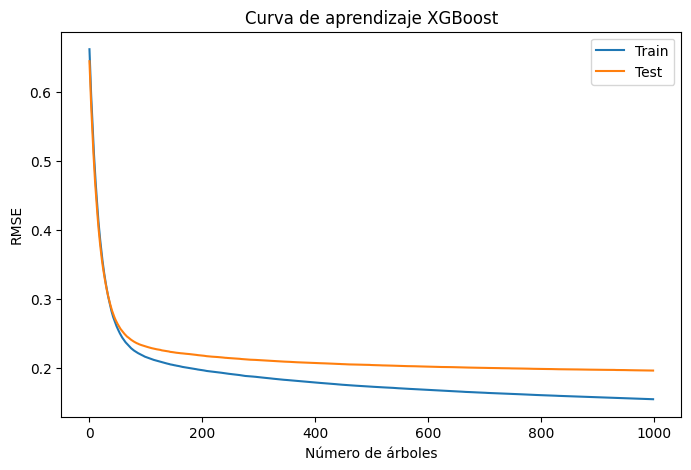

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Definir modelo con muchos árboles
xgb = XGBRegressor(
    n_estimators=1000,  # número alto para observar la curva
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="rmse",
    early_stopping_rounds=50  
)

# Entrenar con conjunto de validación
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Extraer resultados
results = xgb.evals_result()

# Graficar curva de aprendizaje
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
plt.figure(figsize=(8,5))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
plt.xlabel('Número de árboles')
plt.ylabel('RMSE')
plt.title('Curva de aprendizaje XGBoost')
plt.legend()
plt.show()

Forma general:
- Tanto el RMSE de Train como el de Test comienzan alrededor de 0.7 y caen rápidamente a medida que se agregan árboles.
- Después de unas ~100 iteraciones, la caída se suaviza y ambas curvas se “aplanan”.
- La curva de Train sigue bajando lentamente, mientras que la de Test se estabiliza en torno a 0.20.

Sobreajuste (overfitting):
- La separación entre las curvas es un buen indicador de sobreajuste.
- En este caso, el gap Train–Test es pequeño pero creciente:
- A partir de ~200 árboles ya se nota que Train sigue mejorando mientras Test se estanca.
- Esto indica un inicio de overfitting, aunque no es extremo porque la curva de Test no vuelve a subir.

Punto óptimo:
- El modelo alcanza una meseta en Test cerca de los 200–300 árboles.
- Entrenar hasta 1000 árboles no aporta mejoras sustanciales en Test (solo baja en Train).
- Esto sugiere que el número óptimo de árboles debería estar alrededor de 200–300, más allá de eso no vale la pena.

Interpretación práctica:
- El modelo generaliza bien: no hay un salto brusco de Test hacia arriba (que sería sobreajuste fuerte).
- Se podría:
    - Reducir n_estimators (o usar early stopping) en torno a 200–300.
    - Explorar ajustar otros hiperparámetros (max_depth, eta, subsample, colsample_bytree) para reducir aún más la brecha Train–Test.
    - Si el objetivo es mejorar Test, aumentar regularización (reg_alpha, reg_lambda) puede ayudar.

Conclusion:
- Nuestro XGBoost funciona bien con 800 es perfectamente lógico porque tenemos un learning_rate bajo de 0.05.
- Lo importante es no entrenar innecesariamente de más: con early stopping puedes dejar que el modelo decida cuándo parar (aunque hayas puesto n_estimators=1000, por ejemplo).

LightGBM con curva de validación:

[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12042
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1266
[LightGBM] [Warning] Provided parame

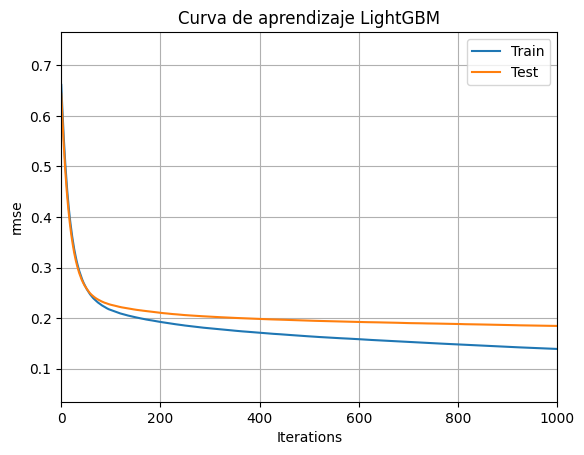

In [21]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Crear dataset LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Parámetros
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Diccionario donde se guardarán las métricas
evals_result = {}

# Entrenar con early stopping + registro de métricas
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['Train','Test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50),
        lgb.record_evaluation(evals_result)  # <-- registra métricas aquí
    ]
)

# Graficar curva de aprendizaje desde evals_result
lgb.plot_metric(evals_result, metric='rmse')
plt.title("Curva de aprendizaje LightGBM")
plt.show()

Forma general:
- Tanto Train como Test parten con un RMSE cercano a 0.7 y caen muy rápido en las primeras ~100 iteraciones.
- A partir de ahí, la mejora es cada vez más lenta y ambas curvas se aplanan progresivamente.
- La curva de Train sigue descendiendo hasta ~0.13, mientras que la de Test se estabiliza alrededor de ~0.18–0.19.

Generalización y sobreajuste:
- La brecha Train–Test es clara: Train mejora continuamente. Test mejora hasta ~200–300 iteraciones y luego se aplana, sin subir.
- Esto indica un sobreajuste moderado: el modelo sigue aprendiendo patrones en entrenamiento que ya no benefician a Test, aunque por suerte no empeora el desempeño en Test.

Punto óptimo:
- El punto de saturación parece estar alrededor de las 200–300 iteraciones (similar al caso con XGBoost).
- Entrenar hasta 1000 iteraciones no aporta mejoras significativas en Test, aunque sí reduce RMSE en Train.

Comparación con XGBoost:
- La forma de ambas curvas (XGBoost y LightGBM) es prácticamente la misma: caída rápida inicial, luego meseta.
- La diferencia principal suele ser que LightGBM entrena más rápido y escala mejor con grandes datasets, aunque el comportamiento de las curvas sea casi idéntico.

Recomendaciones prácticas:
- Usar early stopping para que el entrenamiento se corte alrededor de 200–300 árboles.
- Ajustar hiperparámetros de regularización (min_child_samples, lambda_l1, lambda_l2, feature_fraction) si querés reducir un poco más la brecha Train–Test.
- Si el RMSE en Test ya es suficientemente bueno, lo más importante es no entrenar de más y ahorrar tiempo.

Conclusion:
- Tu modelo con LightGBM generaliza bien, el Test se estabiliza pronto sin empeorar, y no tiene sobreajuste fuerte.
- El punto óptimo está entre 200 y 300 iteraciones. Más allá de eso, solo mejoras en Train, pero sin beneficio en Test.